# **UNLOCKING REAL ESTATE SUCCESS WITH TIME SERIES MODELLING**

This is a collaborative group project done at the end of Phase 4 of Moringa School's Data Science program. The team members of this group include:

- [Abdideq Adan](https://github.com/AdanAbdideq)
- [Clara Gatambia](https://github.com/claragatambia)
- [Isaack Odera](https://github.com/derak-isaack)
- [Mwiti Mwongo](https://github.com/M13Mwongo)
- [Wilson Mutungu](https://github.com/mutungu)

## 1. BUSINESS UNDERSTANDING

TODO - Answer a sample question like why prices would be different in different states but one state may be more expensive on average than another

TODO - Analysis into the market trends (e.g. 2008 financial crash) and how the model may account for that in future (market trend analysis)

TODO - More important to show in depth analysis i.e. data prep and eda

TODO - Think as the investor in this area

### Problem Statement

Real estate represents a significant portion of most people's wealth, and this is especially true for many homeowners in the United States. A number of factors drive the real estate market including government policies, demographics of the potential buyers,affordability, disparity in housing access, location, cash flows and liquidity as well as the current economic climate. The many variables can make the process tedious for the buyers. Naruto consultants hopes to create a predictive time series model that can help to determine the top five zipcodes in which to invest in.

This forecasting model will help adress the anticipation of any other financial crisis with apt predictive capabilities.

### Objectives 
As Naruto consultants, we seek out to:

1. Investigate and establish the 5 best ZipCodes(Regions) that are the best to invest in that guarantee a good Return on investment.

2. Build a time series regression modell to predict the average house prices in the US and top 5 best performing zipcodes.

3. Investigate impact of the 2008 recession on the housing market per ZipCode(Region).

4. Investigate the Metropolitan areas with high economic growth rates in terms of housing.

The objectives of this project are as follows:
 - Identify the key metrics that would be used to classify profitability.
 - Identify the criteria that would classify a house as a "high-end" house or "affordable" house.



### Potential Challenges
- Potentially large amounts of missing data with no conclusive reason, forcing assumptions to be made.
- Some trends may be hard to explain due to differences in locale and perceptions of some matters.
- High seasonality caused by the 2008 market crash.


## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://w0.peakpx.com/wallpaper/957/661/HD-wallpaper-white-marble-white-stone-texture-marble-stone-background-white-stone.jpg)"><b><span style='color:black'> Importing necessary libraries</span></b> </div>

These libraries help us in performing data manipulation, visualizing distributions and performing forecasts. 

In [31]:
# Importing necessary libraries
# Basics
import pandas as pd
import numpy as np
import itertools
from io import StringIO

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline 
import plotly.express as px
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.pylab import rcParams
import time

# Modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA        
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from sklearn.linear_model import LassoLarsCV
from sklearn.model_selection import TimeSeriesSplit 

from prophet import Prophet 
import joblib    


# Warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore')

# Custom Options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',100)


### Definition of Custom Classes / Functions

In line with the concepts of OOP, custom classes were created to speed up the opening and manipulation of data in this project. They are as follows: 

In [2]:
def plot_barplot(dataframe,x,y,x_title,y_title):
  fig,ax = plt.subplots(figsize=(10,8))
  
  sns.barplot(data = dataframe,x=x, y=y,orient='h',errorbar=None)
  ax.set_title(f"{y_title} vs {x_title}")
  ax.set_xlabel(x_title)
  ax.set_ylabel(y_title)
  plt.show()


def plot_histogram(dataframe, x, y, x_title, y_title):
  fig, ax = plt.subplots(figsize=(10, 8))

  sns.histplot(data=dataframe, x=x, y=y, kde=True)
  ax.set_title(f"{y_title} vs {x_title}")
  ax.set_xlabel(x_title)
  ax.set_ylabel(y_title)
  plt.show()

def plot_boxplot(dataframe,x,y,x_title,y_title):
  fig,ax = plt.subplots(figsize=(10,8))
  
  sns.boxplot(data = dataframe,x=x, y=y)
  ax.set_title(f"{y_title} vs {x_title}")
  ax.set_xlabel(x_title)
  ax.set_ylabel(y_title)
  plt.xticks(rotation=90)
  plt.show()

## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://w0.peakpx.com/wallpaper/957/661/HD-wallpaper-white-marble-white-stone-texture-marble-stone-background-white-stone.jpg)"><b><span style='color:black'> Data Understanding</span></b> </div>

In this section after the loading the data, we seek to find a brief overview of the data. This includes:
* the data information.
* The data distribution(shape)
* Check for missing values.


### <b><span style='color:#16C2D5'>|</span> Reading data</b> 

In [3]:
df = pd.read_csv('./data/zillow_data.csv')

The `df.head()` function is used to get a rough look at a few of the records in the dataframe to understand the data better.

In [4]:
df.head(10)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,...,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,...,863900.0,872900.0,883300.0,889500.0,892800,893600,891300,889900,891500,893000,893000,895000,901200,909400,915000,916700,917700,919800,925800,937100,948200,951000,952500,958600,966200,970400,973900,974700,972600,974300,980800,988000,994700,998700,997000,993700,991300,989200,991300,999100,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,215800.0,211100.0,205700.0,200900.0,196800.0,193600.0,191400.0,190400.0,190800.0,192700.0,196000.0,201300.0,207400.0,212200.0,214600.0,215100.0,213400.0,210200.0,206100.0,202100.0,198800.0,196100.0,194100.0,193400.0,193400.0,193100.0,192700.0,193000.0,193700.0,194800.0,196100.0,197800.0,199700.0,201900.0,...,234200.0,235400.0,236600.0,238500.0,240500,242600,244700,246300,247600,249600,251400,253000,255200,258000,261200,264700,268400,271400,273600,275200,276400,277000,277900,280000,282600,285400,288400,290800,292000,292800,293700,295200,297000,299000,300800,301800,302800,304400,306200,307000,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,195400.0,193000.0,191800.0,191800.0,193000.0,195200.0,198400.0,202800.0,208000.0,213800.0,220700.0,227500.0,231800.0,233400.0,233900.0,233500.0,233300.0,234300.0,237400.0,242800.0,250200.0,258600.0,268000.0,277000.0,283600.0,288500.0,293900.0,299200.0,304300.0,308600.0,311400.0,312300.0,311900.0,...,282100.0,284200.0,286000.0,288300.0,290700,293300,295900,298300,300200,301300,301700,302400,303600,306200,309100,311900,314100,316300,319000,322000,324300,326100,327300,327000,327200,328500,329800,330000,329000,327800,326700,325500,324700,324500,323700,322300,320700,320000,320000,320900,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,502200.0,500000.0,497900.0,496300.0,495200.0,494700.0,494900.0,496200.0,498600.0,502000.0,507600.0,514900.0,522200.0,529500.0,537900.0,546900.0,556400.0,566100.0,575600.0,584800.0,593500.0,601600.0,610100.0,618600.0,625600.0,631100.0,636600.0,642100.0,647600.0,653300.0,659300.0,665800.0,672900.0,...,1149900.0,1155200.0,1160100.0,1163300.0,1167700,1173900,1175100,1173500,1175500,1178500,1176400,1174600,1178500,1185700,1192900,1198800,1200400,1198900,1200200,1207400,1218600,1226600,1230700,1235400,1241300,1245700,1247000,1246700,1245700,1246000,1247700,1252900,1260900,1267900,1272600,1276600,1280300,1282500,1286000,1289000,1289800,1287700,1287400,1291500,1296600,129900

The `df.info()` and `df.dtypes` functions are both called to give a rough understanding of the dataframe, and the types of data held in each column. Normally, `df.info()` would be sufficient, but due to the sheer number of columns in the dataframe, that information isn't displayed. Thus, `df.dtypes` is called. 

In [5]:
for data in df.columns:
    print(df[data].info())
    print(df[data].dtypes)

<class 'pandas.core.series.Series'>
RangeIndex: 14723 entries, 0 to 14722
Series name: RegionID
Non-Null Count  Dtype
--------------  -----
14723 non-null  int64
dtypes: int64(1)
memory usage: 115.1 KB
None
int64
<class 'pandas.core.series.Series'>
RangeIndex: 14723 entries, 0 to 14722
Series name: RegionName
Non-Null Count  Dtype
--------------  -----
14723 non-null  int64
dtypes: int64(1)
memory usage: 115.1 KB
None
int64
<class 'pandas.core.series.Series'>
RangeIndex: 14723 entries, 0 to 14722
Series name: City
Non-Null Count  Dtype 
--------------  ----- 
14723 non-null  object
dtypes: object(1)
memory usage: 115.1+ KB
None
object
<class 'pandas.core.series.Series'>
RangeIndex: 14723 entries, 0 to 14722
Series name: State
Non-Null Count  Dtype 
--------------  ----- 
14723 non-null  object
dtypes: object(1)
memory usage: 115.1+ KB
None
object
<class 'pandas.core.series.Series'>
RangeIndex: 14723 entries, 0 to 14722
Series name: Metro
Non-Null Count  Dtype 
--------------  ----- 
13

As expected, all the columns representing time-series data will be storing either an integer or a float data type. It is also important to note that the `RegionID` & `RegionName` are stored as integers - to ensure they are unique - and the remaining 5 columns all contain strings.

The shape of the dataframe was observed as follows: 

In [9]:
# Check for missing values 
df.isnull().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
1997-05       1039
1997-06       1039
1997-07       1038
1997-08       1038
1997-09       1038
1997-10       1038
1997-11       1038
1997-12       1038
1998-01       1036
1998-02       1036
1998-03       1036
1998-04       1036
1998-05       1036
1998-06       1036
1998-07       1036
1998-08       1036
1998-09       1036
1998-10       1036
1998-11       1036
1998-12       1036
1999-01       1036
1999-02       1036
1999-03       1036
1999-04       1036
1999-05       1036
1999-06       1036
1999-07       1036
1999-08       1036
1999-09       1036
1999-10       1036
1999-11       1036
1999-12       1036
2000-01     

Aside from the columns that contain time-series values, only the metro column has null values. This can be seen as inconsequential as there is enough data from the other columns to overlook this. 

Taking a closer look at the missing time-series values, there seems to be a steady trend. The values do not appear to be random, as they steadily decrease from April 1996 to July 2014, from where they remain 0 throughout till April 2018.

The gradual change indicates that the presence of null values in these columns is anything but random. As such, when dealing with the null values in the time-series value columns, **all null values will be left as is**. No replacement or removal of records will be done. This is done as it is assumped that not all the houses were built at the same time, thus it is expected that there will be null values for some houses and not others. Furthermore, some of these null values are attributed to the differential times that the houses were put on the market.

When dealing with the null values in the metro column, all null values will be left as the data missing does not impact the objectives of the project. 



In [10]:
# Check for duplicate values
df.duplicated().sum()

0

In [6]:
df.shape

(14723, 272)

The dataframe has 14723 records and 272 column. However, majority of those columns represent the time series values. The first seven columns - `RegionID`, `RegionName`, `City`, `State`, `Metro`, `CountyName` and `SizeRank` - are the columns that give us more information about the dataset. 

Each of these columns is intended to hold a certain type of data as follows: 
- *RegionID*: The unique ID of the region in question.
- *RegionName*: The name of the region in question.
- *City*: The name of the city within a given region.
- *State*: The state in which the RegionID is found.
- *Metro*: The metropolitan name within which the RegionID is found.
- *CountyName*: The name of the county within a given region.
- *SizeRank*: The region's area ranking vis-a-vis other regions, organised in descending order.

Going forward, these columns shall be referred to as the `columns of interest`, while the remaining columns shall be referred to as the `time_series_cols`.

In [7]:
# ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName','SizeRank']

cols_of_interest = df.columns[:7]
cols_of_interest

Index(['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank'],
      dtype='object')

In [8]:
time_series_cols = df.columns[-265:]
time_series_cols

Index(['1996-04', '1996-05', '1996-06', '1996-07', '1996-08', '1996-09',
       '1996-10', '1996-11', '1996-12', '1997-01',
       ...
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04'],
      dtype='object', length=265)

The last 265 columns all need to be datetime columns. 

## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://w0.peakpx.com/wallpaper/957/661/HD-wallpaper-white-marble-white-stone-texture-marble-stone-background-white-stone.jpg)"><b><span style='color:black'> Data Preprocessing</span></b> </div>

In [11]:
# Ensuring all time series columns are converted to float64 i.e. the last 265 columns

for col in time_series_cols:
  if df[col].dtype is not 'float64':
    df[col] = df[col].astype('float64')


df.dtypes

RegionID        int64
RegionName      int64
City           object
State          object
Metro          object
CountyName     object
SizeRank        int64
1996-04       float64
1996-05       float64
1996-06       float64
1996-07       float64
1996-08       float64
1996-09       float64
1996-10       float64
1996-11       float64
1996-12       float64
1997-01       float64
1997-02       float64
1997-03       float64
1997-04       float64
1997-05       float64
1997-06       float64
1997-07       float64
1997-08       float64
1997-09       float64
1997-10       float64
1997-11       float64
1997-12       float64
1998-01       float64
1998-02       float64
1998-03       float64
1998-04       float64
1998-05       float64
1998-06       float64
1998-07       float64
1998-08       float64
1998-09       float64
1998-10       float64
1998-11       float64
1998-12       float64
1999-01       float64
1999-02       float64
1999-03       float64
1999-04       float64
1999-05       float64
1999-06   

### c) Data Handling

### <b>I<span style='color:#16C2D5'>|</span> Data aggregation</b> 

As all values in the time-series columns are deemed important, aggregating the data to a yearly basis, for example, at such an early stage was deemed unnecessary. This is because a lot of vital information would be lost in the process that would be necessary later on. Thus, aggregation would be done on an as-needed basis.

### <b>II<span style='color:#16C2D5'>|</span> Grouping data</b> 

Data will now be grouped by state, to give a better idea as to which states have more property listings than others:

In [11]:
df[['State', 'RegionID','RegionName','City','Metro','CountyName','SizeRank']].groupby("State").count().head(5)

,RegionID,RegionName,City,Metro,CountyName,SizeRank
State,,,,,,
AK,28,28,28,22,28,28
AL,183,183,183,175,183,183
AR,105,105,105,100,105,105
AZ,230,230,230,228,230,230
CA,1224,1224,1224,1182,1224,1224


Particular focus will be placed on the `RegionID` as that column does not have any null values, thus an accurate count of properties can be done. This column will appropriately be renamed to `Count of Properties` as it signifies the count of properties in a particular state.

In [13]:
df_state_grouping = df[['State', 'RegionID']].groupby(
    "State").count().sort_values(by='RegionID', ascending=False).head(10)
df_state_grouping.reset_index(inplace=True)
df_state_grouping.rename(columns={'RegionID': 'Count of Properties'}, inplace=True)
df_state_grouping

,State,Count of Properties
0,CA,1224
1,NY,1015
2,TX,989
3,PA,831
4,FL,785
5,OH,588
6,IL,547
7,NJ,502
8,MI,499
9,IN,428


California (CA) is seen to have the most listings with 1224, followed closely by New York, NY (1015) and Texas, TX (989). Vermont (VT), Washington DC (DC) and San Diego (SD) have the least listings at 16, 18 and 19 respectively. 

### <b>III<span style='color:#16C2D5'>|</span> Outliers</b>  

There will be outliers present in the data, that will be more apparent in the EDA section. These outliers may come around as a result of over-inflated house prices, or simply having houses marked below their market value by owners who are in a rush to sell. Whatever the case may be, the outliers in the dataset **will be kept throughout the analysis**. 

These outliers play an important role in developing a more realistic model, as the world of real-estate will always have overpriced or underpriced properties that do not conform to the norms. Keeping these outliers in will serve to create a more realistic model.

## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://w0.peakpx.com/wallpaper/957/661/HD-wallpaper-white-marble-white-stone-texture-marble-stone-background-white-stone.jpg)"><b><span style='color:black'>  Feature Engineering</span></b> </div>

### <b>3.1 <span style='color:#16C2D5'>|</span> New Feature addittion</b> 

Relevant features that could affect house prices were noted and their creation was deemed necessary. These features are: 

- *Return On Investment(ROI)(%)*: Calculated as 
$
\left( \frac{{\text{{Last Price of Property}}}}{{\text{{Initial Price of Property}}}} - 1 \right) \times 100\% 
$

As we know that the latter, and in particular the last time-series column, has no null values, this column will automatically be our numerator (i.e. `df.columns[271]`). As for the denominator, it's value will be occuppied by the oldest datetime that is not a null value. Therefore, the calculation of the ROI was done as follows:

In [14]:
df_feature_engineered = df.copy()

for index, row in df_feature_engineered.iterrows():
  # Establishing the last price of the property
  last_price = df_feature_engineered.columns[271]

  # Establishing the initial price of the property
  initial_price = 0

  # Loop through time_series_cols to find the first non-null value
  for col in time_series_cols:
      initial_price = df_feature_engineered[col].values[index]
      if not pd.isnull(initial_price):
        # print(f"Record {index} initial price: {initial_price} @ {col}")
        break
  df_feature_engineered.at[index, 'Initial Price'] = initial_price
  
  df_feature_engineered['Last Price'] = df[last_price]
  
  df_feature_engineered['ROI (%)'] = round(
      (((df_feature_engineered['Last Price'] / df_feature_engineered['Initial Price']) - 1) * 100), 2)

df_feature_engineered.head(10)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,...,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,Initial Price,Last Price,ROI (%)
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,337600.0,338500.0,339500.0,340400.0,341300.0,342600.0,344400.0,345700.0,346700.0,347800.0,349000.0,350400.0,352000.0,353900.0,356200.0,358800.0,361800.0,365700.0,370200.0,374700.0,378900.0,383500.0,388300.0,393300.0,398500.0,403800.0,409100.0,414600.0,420100.0,426200.0,432600.0,438600.0,444200.0,450000.0,455900.0,462100.0,468500.0,475300.0,482500.0,490200.0,...,889500.0,892800.0,893600.0,891300.0,889900.0,891500.0,893000.0,893000.0,895000.0,901200.0,909400.0,915000.0,916700.0,917700.0,919800.0,925800.0,937100.0,948200.0,951000.0,952500.0,958600.0,966200.0,970400.0,973900.0,974700.0,972600.0,974300.0,980800.0,988000.0,994700.0,998700.0,997000.0,993700.0,991300.0,989200.0,991300.0,999100.0,1005500.0,1007500.0,1007800.0,1009600.0,1013300.0,1018700.0,1024400.0,1030700.0,1033800.0,1030600.0,334200.0,1030600.0,208.38
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,235400.0,233300.0,230600.0,227300.0,223400.0,219600.0,215800.0,211100.0,205700.0,200900.0,196800.0,193600.0,191400.0,190400.0,190800.0,192700.0,196000.0,201300.0,207400.0,212200.0,214600.0,215100.0,213400.0,210200.0,206100.0,202100.0,198800.0,196100.0,194100.0,193400.0,193400.0,193100.0,192700.0,193000.0,193700.0,194800.0,196100.0,197800.0,199700.0,201900.0,...,238500.0,240500.0,242600.0,244700.0,246300.0,247600.0,249600.0,251400.0,253000.0,255200.0,258000.0,261200.0,264700.0,268400.0,271400.0,273600.0,275200.0,276400.0,277000.0,277900.0,280000.0,282600.0,285400.0,288400.0,290800.0,292000.0,292800.0,293700.0,295200.0,297000.0,299000.0,300800.0,301800.0,302800.0,304400.0,306200.0,307000.0,308000.0,310000.0,312500.0,314100.0,315000.0,316600.0,318100.0,319600.0,321100.0,321800.0,235700.0,321800.0,36.53
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,210700.0,208300.0,205500.0,202500.0,199800.0,198300.0,197300.0,195400.0,193000.0,191800.0,191800.0,193000.0,195200.0,198400.0,202800.0,208000.0,213800.0,220700.0,227500.0,231800.0,233400.0,233900.0,233500.0,233300.0,234300.0,237400.0,242800.0,250200.0,258600.0,268000.0,277000.0,283600.0,288500.0,293900.0,299200.0,304300.0,308600.0,311400.0,312300.0,311900.0,...,288300.0,290700.0,293300.0,295900.0,298300.0,300200.0,301300.0,301700.0,302400.0,303600.0,306200.0,309100.0,311900.0,314100.0,316300.0,319000.0,322000.0,324300.0,326100.0,327300.0,327000.0,327200.0,328500.0,329800.0,330000.0,329000.0,327800.0,326700.0,325500.0,324700.0,324500.0,323700.0,322300.0,320700.0,320000.0,320000.0,320900.0,321000.0,320600.0,320200.0,320400.0,320800.0,321200.0,321200.0,323000.0,326900.0,329900.0,210400.0,329900.0,56.80
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,504600.0,505500.0,505700.0,505300.0,504200.0,503600.0,503400.0,502200.0,500000.0,497900.0,496300.0,495200.0,494700.0,494900.0,496200.0,498600.0,502000.0,507600.0,514900.0,522200.0,529500.0,537900.0,546900.0,556400.0,566100.0,575600.0,584800.0,593500.0,601600.0,610100.0,618600.0,625600.0,631100.0,636600.0,642100.0,647600.0,653300.0,659300.0,665800.0,672900.0,...,1163300.0,1167700.0,1173900.0,1175100.0,1173500.0,1175500.0,1178500.0,1176400.0,1174600.0,117850

### <b>3.1 <span style='color:#16C2D5'>|</span> Normalization and Scaling</b> 

Having gone through the data, no different scales are noticed. However, there may be a need for normalization when it comes to comparing regions with vastly different quantities of properties listed that have a variety of prices. This is to ensure that the comparison is as accurate as possible and without an inherent bias or skew. This shall be done later on in the EDA stages on an as-needed basis

A new dataframe is now created which contains the melted data. This will convert the original dataframe `df` from wide to long format. This will be done by applying the custom function `melt_data`

In [16]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """

    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank',
                     'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna()
    return melted 

Converting the dataframe to long format:

In [19]:
df_eda = melt_data(df)
df_eda.head()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
0,60657,84654,1,Chicago,IL,Chicago,Cook,1996-04-01,334200.0
1,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,1996-04-01,235700.0
2,77494,91982,3,Katy,TX,Houston,Harris,1996-04-01,210400.0
3,60614,84616,4,Chicago,IL,Chicago,Cook,1996-04-01,498100.0
4,79936,93144,5,El Paso,TX,El Paso,El Paso,1996-04-01,77300.0


In [20]:
df_eda['Year'] = df_eda['time'].dt.year
df_eda['Month'] = df_eda['time'].dt.month 

## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://w0.peakpx.com/wallpaper/957/661/HD-wallpaper-white-marble-white-stone-texture-marble-stone-background-white-stone.jpg)"><b><span style='color:black'> Explorative Data Analysis</span></b> </div>

### Descriptive Statistics

The mean, median & standard deviation (as well as other statistics) are seen here: 

In [17]:
df.describe()

,RegionID,RegionName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,...,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
count,14723.000000,14723.000000,14723.000000,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368400e+04,1.368500e+04,1.368500e+04,1.368500e+04,1.368500e+04,1.368500e+04,1.368500e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,1.368700e+04,...,1.466700e+04,1.466700e+04,1.466700e+04,1.466700e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04,1.472300e+04
mean,81075.010052,48222.348706,7362.000000,1.182991e+05,1.184190e+05,1.185374e+05,1.186531e+05,1.187803e+05,1.189275e+05,1.191205e+05,1.193454e+05,1.196851e+05,1.201213e+05,1.205442e+05,1.208966e+05,1.212682e+05,1.216559e+05,1.220531e+05,1.224563e+05,1.228799e+05,1.233274e+05,1.238231e+05,1.243537e+05,1.250026e+05,1.257367e+05,1.264508e+05,1.270863e+05,1.277364e+05,1.283850e+05,1.290327e+05,1.296764e+05,1.303245e+05,1.309826e+05,1.316781e+05,1.323993e+05,1.332247e+05,1.341336e+05,1.350209e+05,1.358416e+05,1.366838e+05,1.375321e+05,1.383918e+05,1.392652e+05,1.401606e+05,1.410848e+05,1.420701e+05,1.431040e+05,1.442613e+05,1.455221e+05,1.467723e+05,...,2.250826e+05,2.261248e+05,2.272320e+05,2.283106e+05,2.290993e+05,2.301417e+05,2.310600e+05,2.319275e+05,2.328221e+05,2.337123e+05,2.346912e+05,2.357603e+05,2.368364e+05,2.380098e+05,2.393542e+05,2.407441e+05,2.421035e+05,2.434244e+05,2.446583e+05,2.457646e+05,2.467650e+05,2.477652e+05,2.488964e+05,2.499873e+05,2.510143e+05,2.521643e+05,2.534836e+05,2.548201e+05,2.562058e+05,2.575979e+05,2.589460e+05,2.602543e+05,2.615769e+05,2.629238e+05,2.643733e+05,2.657551e+05,2.670651e+05,2.685335e+05,2.702268e+05,2.718247e+05,2.733354e+05,2.748658e+05,2.764646e+05,2.780332e+05,2.795209e+05,2.810953e+05,2.826571e+05,2.843687e+05,2.865114e+05,2.880399e+05
std,31934.118525,29359.325439,4250.308342,8.600251e+04,8.615567e+04,8.630923e+04,8.646795e+04,8.665094e+04,8.687208e+04,8.715185e+04,8.747981e+04,8.791269e+04,8.840935e+04,8.887373e+04,8.927704e+04,8.969700e+04,9.012583e+04,9.056147e+04,9.100389e+04,9.146850e+04,9.196320e+04,9.250608e+04,9.308367e+04,9.374830e+04,9.445247e+04,9.510499e+04,9.567485e+04,9.624843e+04,9.681400e+04,9.737949e+04,9.794880e+04,9.853754e+04,9.915791e+04,9.983302e+04,1.005517e+05,1.013752e+05,1.022670e+05,1.031269e+05,1.039398e+05,1.048064e+05,1.057199e+05,1.066999e+05,1.077590e+05,1.089064e+

### Data Analysis

The listings per state were looked at and plotted on a simple bar graph:

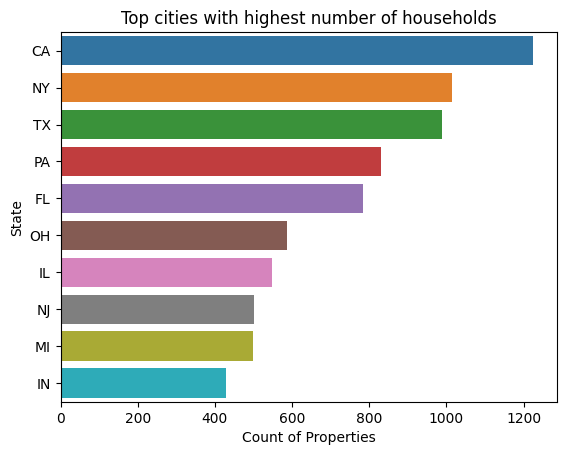

In [15]:
sns.barplot(data=df_state_grouping, y='State',x='Count of Properties')
plt.title("Top cities with highest number of households")
plt.show()

This same analysis can be done to observe the spread of property listings in the various cities and counties.

In [ ]:
group1 = df.groupby(['RegionID', 'RegionID'])['CountyName'].agg('count').sort_values(ascending=False).head(10)
sns.barplot(data=group1.reset_index(), x='CountyName', y='')

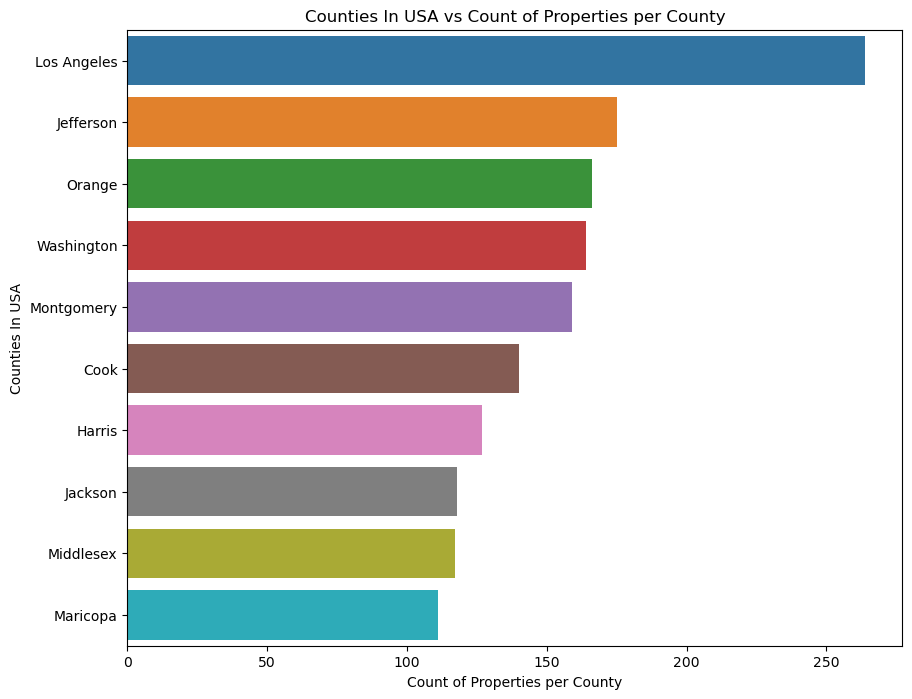

In [27]:
plot_barplot(dataframe=df[['RegionID', 'CountyName']].groupby('CountyName').count().reset_index().sort_values(
    by='RegionID', ascending=False).head(10), y='CountyName', x='RegionID', y_title='Counties In USA', x_title='Count of Properties per County')

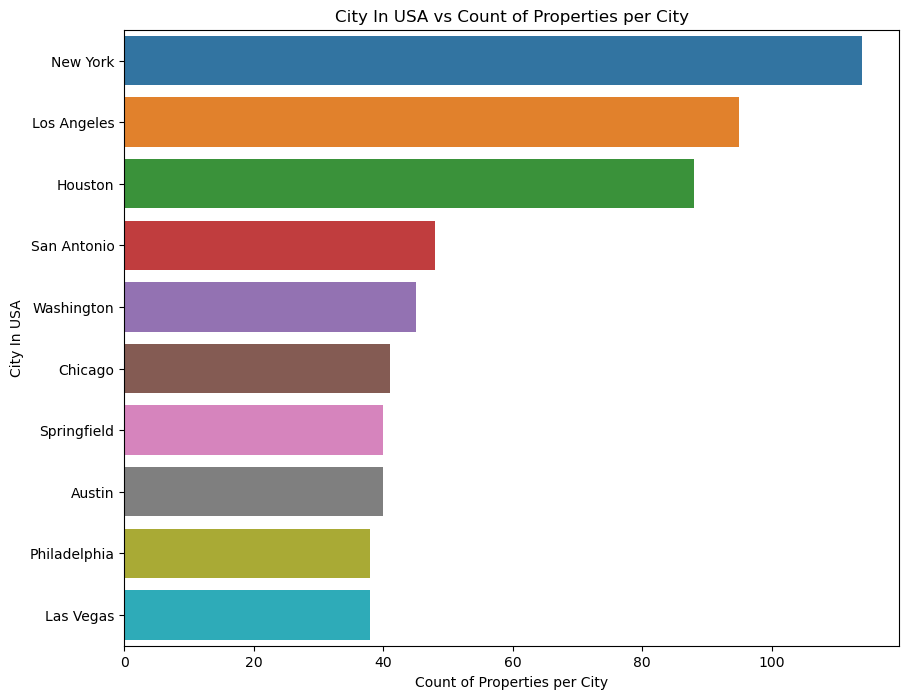

In [29]:
plot_barplot(dataframe=df[['RegionID', 'City']].groupby('City').count().reset_index().sort_values(
    by='RegionID', ascending=False).head(10), y='City', x='RegionID', y_title='City In USA', x_title='Count of Properties per City')

In [21]:
group_metropolitan = pd.DataFrame(df_eda.groupby(['Metro','RegionName'])['value'].agg('mean').sort_values(ascending=False).head(30))
group_metropolitan 

value
Metro                          RegionName              
New York                       10021       1.285427e+07
                               10011       7.755844e+06
                               10014       6.836902e+06
                               10128       5.085436e+06
San Francisco                  94027       3.487129e+06
Glenwood Springs               81611       3.147124e+06
Los Angeles-Long Beach-Anaheim 90210       2.789977e+06
Miami-Fort Lauderdale          33480       2.634498e+06
San Francisco                  94123       2.630977e+06
Brunswick                      31561       2.403194e+06
San Francisco                  94115       2.399030e+06
                               94109       2.395636e+06
Glenwood Springs               81615       2.300179e+06
Los Angeles-Long Beach-Anaheim 90402       2.292232e+06
San Diego                      92067       2.170122e+06
Los Angeles-Long Beach-Anaheim 90020       2.149644e+06
San Francisco                  94028       2.131495e+06
San Jose                       94301       2.084380e+06
New York                       7620        2.080074e+06
Los Angeles-Long Beach-Anaheim 92657       2.070006e+06
San Jose                       94022       2.066818e+06
San Francisco                  94957       2.043843e+06
Santa Maria-Santa Barbara      93108       1.991682e+06
New York                       11217       1.977407e+06
San Jose                       94305       1.918675e+06
Boston                         2116        1.887043e+06
Los Angeles-Long Beach-Anaheim 90265       1.876195e+06
San Francisco                  94133       1.833388e+06
New York                       11976       1.803404e+06
Los Angeles-Long Beach-Anaheim 90049       1.799291e+06

<AxesSubplot: xlabel='State', ylabel='value'>

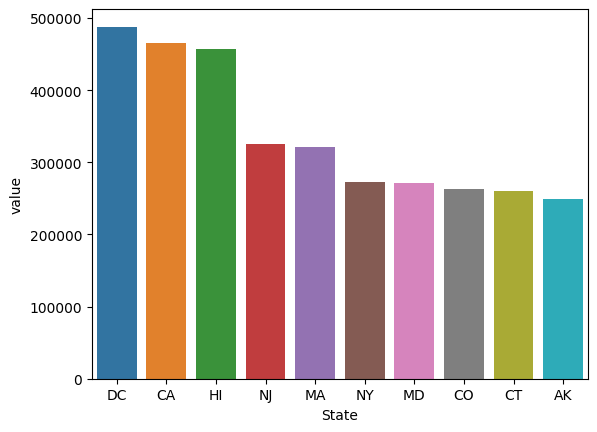

In [22]:
# Average house prices by state 
state_group = df_eda.groupby('State')['value'].agg('mean').sort_values(ascending=False).head(10)

sns.barplot(data=state_group.reset_index(), x='State', y='value')

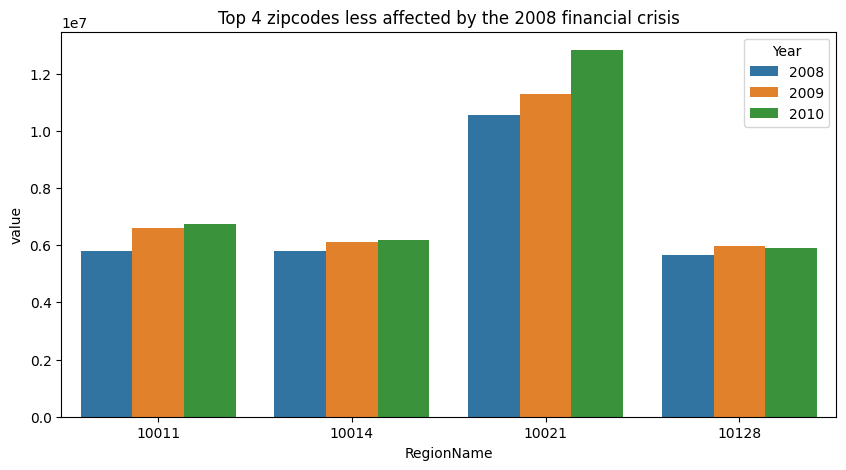

In [23]:
regions = [10021, 10011, 10014, 10128, 94027, 81611, 90210, 33480, 94123, 31561,
                   94115, 94109, 81615, 90402, 92067, 90020, 94028, 94301, 7620, 92657,
                   94022, 94957, 93108, 11217, 94305, 2116, 90265, 94133, 11976, 90049]


years = [2008, 2009, 2010]

plt.figure(figsize=(10,5))
filtered_df = df_eda[(df_eda['Year'].isin(years)) & df_eda['RegionName'].isin(regions)]
group_crisis = pd.DataFrame(filtered_df.groupby(['RegionName','Year'])['value'].agg('mean').sort_values(ascending=False)).head(12)
sns.barplot(data=group_crisis.reset_index(), x='RegionName', y='value', hue='Year')
plt.title("Top 4 zipcodes less affected by the 2008 financial crisis")
plt.show()


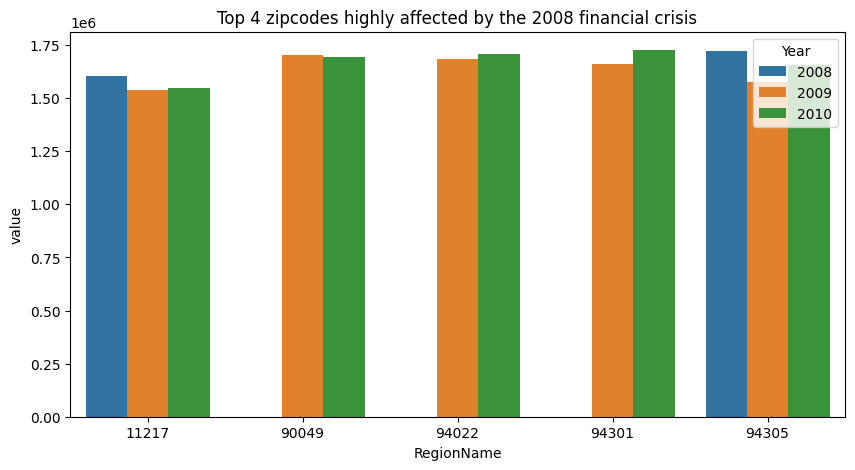

In [24]:
plt.figure(figsize=(10,5))
group_crisis2 = pd.DataFrame(filtered_df.groupby(['RegionName','Year'])['value'].agg('mean').sort_values(ascending=True)).head(12)
sns.barplot(data=group_crisis2.reset_index(), x='RegionName', y='value', hue='Year')
plt.title("Top 4 zipcodes highly affected by the 2008 financial crisis")
plt.show()

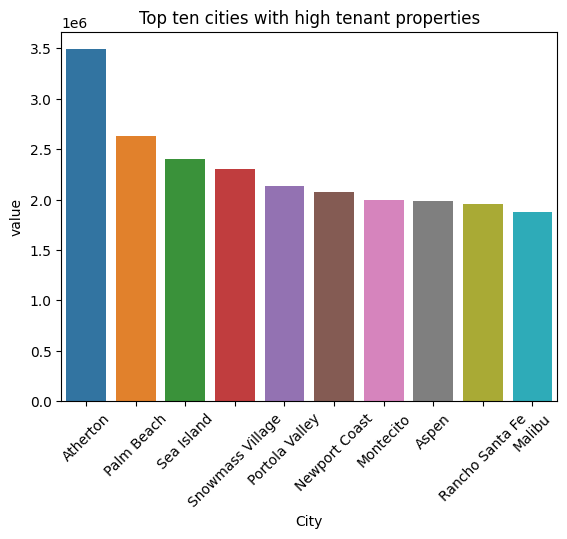

In [25]:
group_cities = pd.DataFrame(df_eda.groupby('City')['value'].agg('mean').sort_values(ascending=False)).head(10)

sns.barplot(data=group_cities.reset_index(), x='City', y='value')
plt.title("Top ten cities with high tenant properties")
plt.xticks(rotation=45)
plt.show() 

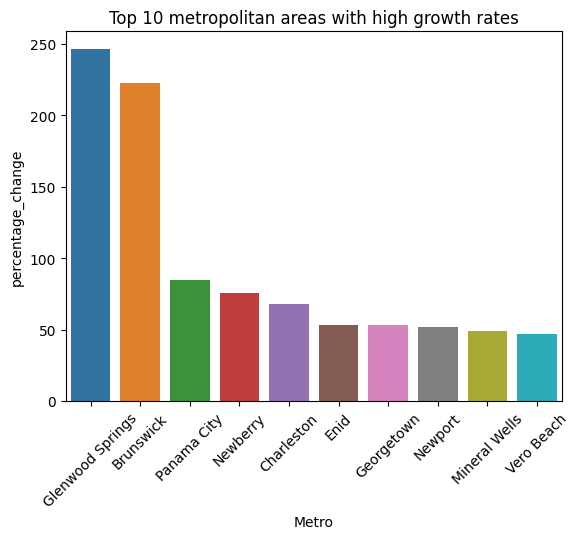

In [26]:

df_eda['percentage_change'] = df_eda.groupby('Metro')['value'].pct_change() * 100

average_percentage_change = pd.DataFrame(df_eda.groupby('Metro')['percentage_change'].mean().sort_values(ascending=False)).head(10)
sns.barplot(data=average_percentage_change.reset_index(), x='Metro', y='percentage_change')
plt.title("Top 10 metropolitan areas with high growth rates")
plt.xticks(rotation=45)
plt.show()


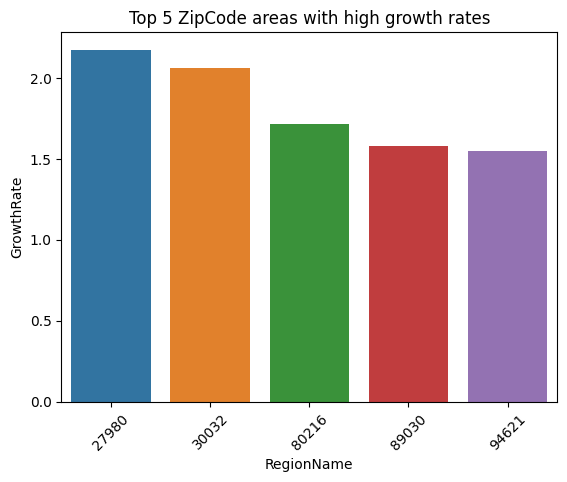

In [27]:

df_eda['GrowthRate'] = df_eda.groupby('RegionName')['value'].pct_change() * 100

average_pct_change = pd.DataFrame(df_eda.groupby('RegionName')['GrowthRate'].mean().sort_values(ascending=False)).head(5)
sns.barplot(data=average_pct_change.reset_index(), x='RegionName', y='GrowthRate')
plt.title("Top 5 ZipCode areas with high growth rates")
plt.xticks(rotation=45)
plt.show()


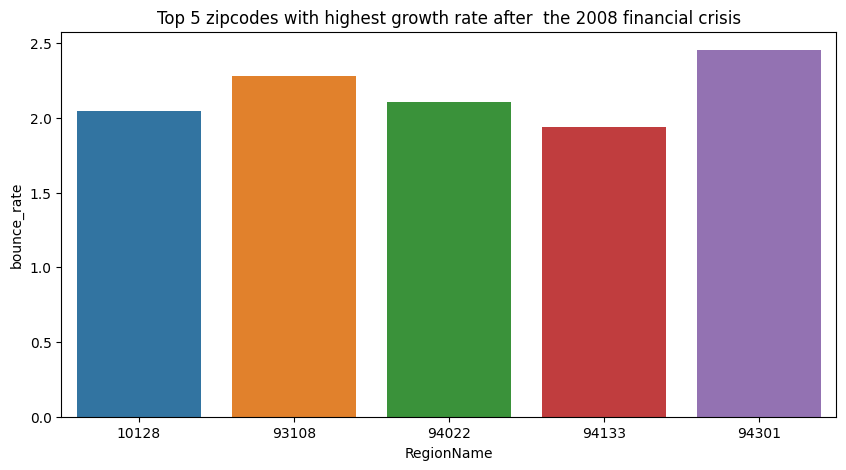

In [28]:
# Investigate among the high end estates, which regions specifically zip codes that had a good growth rate after the crisis. 
years2 = [2011, 2012, 2013, 2014, 2015 ]

plt.figure(figsize=(10,5))
filtered_df2 = df_eda[(df_eda['Year'].isin(years2)) & (df_eda['RegionName'].isin(regions))]
filtered_df2['bounce_rate'] = df_eda.groupby('RegionName')['value'].pct_change() * 100
group_crisis = pd.DataFrame(filtered_df2.groupby(['RegionName','Year'])['bounce_rate'].agg('mean').sort_values(ascending=False)).head(5)
sns.barplot(data=group_crisis.reset_index(), x='RegionName', y='bounce_rate')
plt.title("Top 5 zipcodes with highest growth rate after  the 2008 financial crisis")
plt.show()

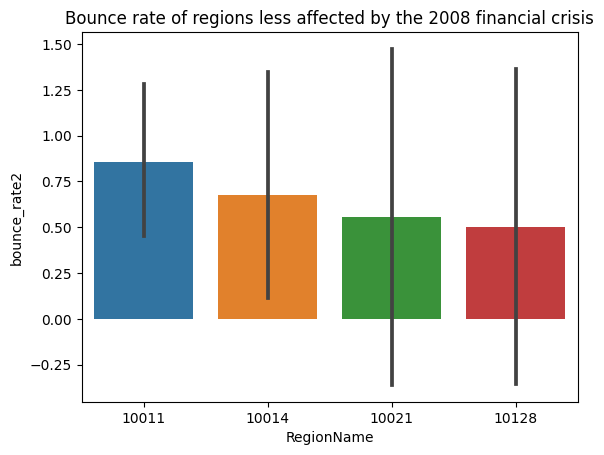

In [29]:
regions2 = [10011, 10014, 10021, 10128]

filtered_df2 = df_eda[(df_eda['Year'].isin(years2)) & (df_eda['RegionName'].isin(regions2))]
filtered_df2['bounce_rate2'] = df_eda.groupby('RegionName')['value'].pct_change() * 100
group_crisis = pd.DataFrame(filtered_df2.groupby(['RegionName','Year'])['bounce_rate2'].agg('mean').sort_values(ascending=False))
sns.barplot(data=group_crisis.reset_index(), x='RegionName', y='bounce_rate2')
plt.title("Bounce rate of regions less affected by the 2008 financial crisis")
plt.show()


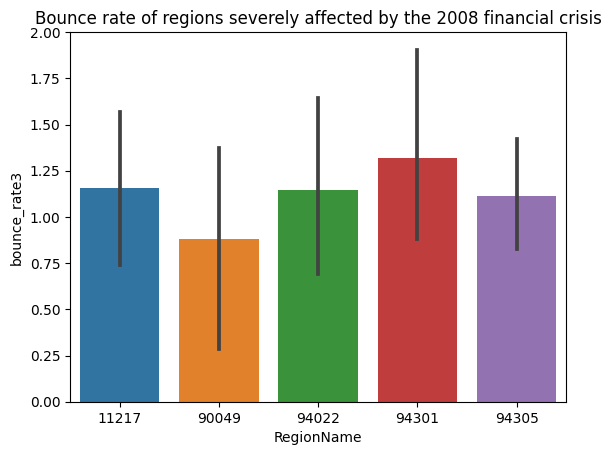

In [30]:
regions3 = [11217, 90049, 94022, 94301, 94305]

filtered_df3 = df_eda[(df_eda['Year'].isin(years2)) & (df_eda['RegionName'].isin(regions3))]
filtered_df3['bounce_rate3'] = df_eda.groupby('RegionName')['value'].pct_change() * 100
group_crisis3 = pd.DataFrame(filtered_df3.groupby(['RegionName','Year'])['bounce_rate3'].agg('mean').sort_values(ascending=False))
sns.barplot(data=group_crisis3.reset_index(), x='RegionName', y='bounce_rate3')
plt.title("Bounce rate of regions severely affected by the 2008 financial crisis")
plt.show()

### <b> <span style='color:#16C2D5'>|</span> EDA Conclusion</b>

* Wasington DC has the highest priced homes. 
* ZipCodes **10021, 10011, 10014 and 10128 were among the top priced regions less affected by the 2008 financial crisis. 
* Glenwood Springs, Brunswick are the cities with high growth rates of 250% and 225%.
* Zipcode 10011 had the highest bounce back rate of 0.85% after the market crush.
* ZipCode 94301 and 94022 which were severely affected by the crisis had the highest rates at 1.3% and 1.1% respectively. 


## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://w0.peakpx.com/wallpaper/957/661/HD-wallpaper-white-marble-white-stone-texture-marble-stone-background-white-stone.jpg)"><b><span style='color:black'> 3. Modelling </span></b> </div>


Modelling in time series involves the use of Auto Regressive models which uses lagged features to predict the future values. Since most time series data always has the component of trend and sesonality, the ARIMA models have the idea of differencing to ensure stationarity. This is also one of the assumptions of ARMA models. 

With that said, the data we have has to be transformed from the wide formart to the long formart to ensure uniformity and an easy resampling and modelling process. 

In this section, we seek out to build a forecasting model to predict the house prices for the **ZipCodes** which are high priced and have good prospects for  a good **Return on Investment**. This will finally help us have a solid recommendation to give to our investors regarding the best zipCodes to invest in. 

The conents of this phase include:
* Transforming data 
* Data Resampling 
* Baseline model 
* Auto Arima model 
* Arima Models
* Facebook Prophet(ETL pipeline) 

In [32]:
df_model = melt_data(df)
df_model.set_index('time', inplace=True)

Setting the time as the index column allows easier resampling as well as slicing of data. The from the melting function has many rows and as such training would only need a fraction or small sample of the data to represent the whole population. It is computationally expensive to run models on very huge sets of data especially ARMA models. They are not efficient to handle big data. 

In [33]:
df_model.head()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,value
time,,,,,,,,
1996-04-01,60657,84654,1,Chicago,IL,Chicago,Cook,334200.0
1996-04-01,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,235700.0
1996-04-01,77494,91982,3,Katy,TX,Houston,Harris,210400.0
1996-04-01,60614,84616,4,Chicago,IL,Chicago,Cook,498100.0
1996-04-01,79936,93144,5,El Paso,TX,El Paso,El Paso,77300.0


### <b> <span style='color:#16C2D5'>|</span> Data Resampling</b> 
Data resampling in Time series data is very important because it aggregates data on a different frequency than what it was collected and changes frequency of a time series data. Resampling serves to **remove noise** or rather **random fluctuations**.
The various ways to resample data are: 
**A - Year End, M - Month end, W - Weekly, D - Daily and MS - Month start**. The data at our disposal seems to be on a month start basis and that is the best resampling technique for this problem. 


<AxesSubplot: xlabel='time'>

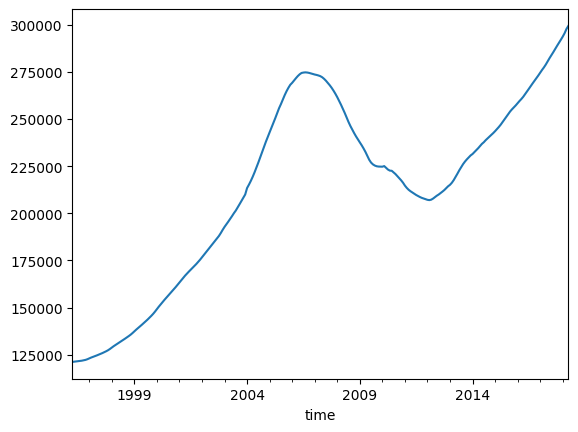

In [34]:
df_model2 = df_model['value'].resample('MS').mean()
df_model2.plot()

The plot from the monthly resampled data shows a steday growth from 1999 upto 2007. This was greatly attribute to the subprime housing mortgages given to low income earners. As from 2008, there is a increasingly staedy drop in the value of houses and this was due to the housing market crash in 2008 This is the period when the **US** had a housing Crisis majorly caused by subprime mortgages, huge debts and low regulation in the financial sector. The value of homes dropped and many home owners and investors could not keep up with their mortgages.

As outlined in [https://www.investopedia.com/articles/economics/09/subprime-market-2008.asp], the US was faced with a financial crisis when the housing syatem collapsed and value of house prices plummuted. 

This housing project by the government was however cut short by the ever increasing default rates and debts caused by the high risk mortgages given by the US government. Many of the low income earners would pay up low initial payments and thereafter huge interest rates. This build up of debts caused a major reccession to the point of the government bailing out home owners because most ended up bankrupt with low value homes. 



In [35]:
# Function for the autocorrellation plots 
def corr_plots(data):
    acf_diff = plot_acf(data)
    pacf_plot = plot_pacf(data)
    adfttest = adfuller(data)
    print(f"The p value is {adfttest[1]}")
    
    return acf_diff, pacf_plot

The p value is 0.27562767729226234


(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

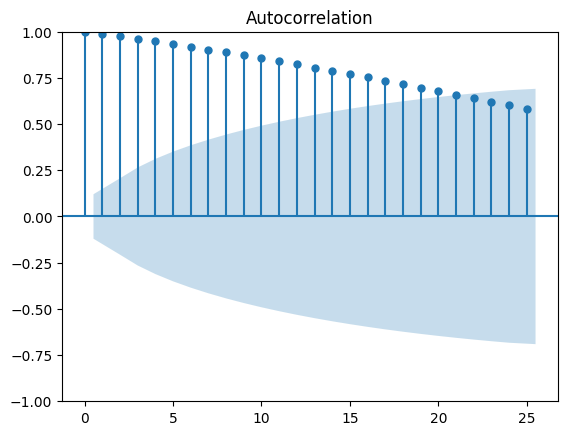

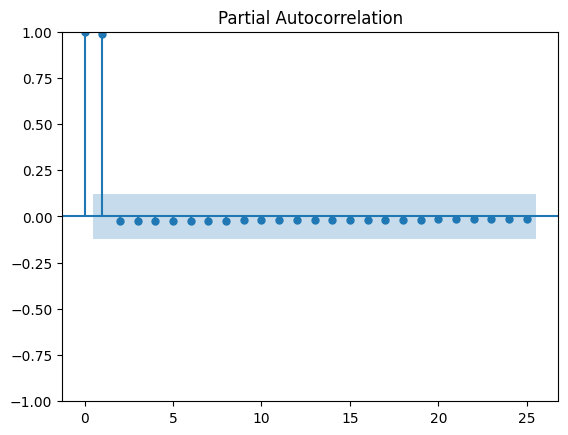

In [36]:
corr_plots(df_model2)

From the auto-correlation plots, it is very evident that the house value drop between 2008 and 2012 introduced very high seasonality.

## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://w0.peakpx.com/wallpaper/957/661/HD-wallpaper-white-marble-white-stone-texture-marble-stone-background-white-stone.jpg)"><b><span style='color:black'> Baseline model</span></b> </div>
Building a forecasting model on the whole data seems infeasible. We seek to narrow down the forecast to only the afore mentioned **top 30 zipcodes** with the highest prices. 

The approach taken was looping through the zipcodes column, train a baseline model, forecast using lagged values and finally saving the forecasted values together with their respective percentage change. The **TimseSeriesSplit** is used to split the data into train and test splits on the index column. The baseline model uses the **pdq values** of order **1,0,1** as obtained from the correlation plots. 

In [51]:

unique_counties = [10021, 10011, 10014, 10128, 94027, 81611, 90210, 33480, 94123, 31561,
                   94115, 94109, 81615, 90402, 92067, 90020, 94028, 94301, 7620, 92657,
                   94022, 94957, 93108, 11217, 94305, 2116, 90265, 94133, 11976, 90049]

tsc = TimeSeriesSplit(n_splits=5)

all_train_dates, all_test_dates = [], []
all_train_values, all_test_values = [], []
all_forecasts = []

results_list1 = []

for county in unique_counties:
    county_data = df_model[df_model['RegionName'] == county]

    # Split the data 
    dates = county_data.index
    values = county_data['value'].values

    # accumulate values for each fold
    zip_train_dates, zip_test_dates = [], []
    zip_train_values, zip_test_values = [], []

    for train_index, test_index in tsc.split(dates):
        train_dates, test_dates = dates[train_index], dates[test_index]
        train_values, test_values = values[train_index], values[test_index]

        zip_train_dates.extend(train_dates)
        zip_test_dates.extend(test_dates)
        zip_train_values.extend(train_values)
        zip_test_values.extend(test_values)

        
        baseline_model = ARIMA(train_values, order=(1, 0, 1)).fit()
        forecast = pd.Series(baseline_model.predict(start=len(train_values), end=len(train_values) + 11, typ='levels'))
        
        print(baseline_model.summary())

        all_forecasts.extend(forecast)

    
        forecasted_value = forecast.iloc[-1]
        real_value = test_values[-1]
        percentage_change = ((forecasted_value - real_value) / real_value) * 100

        results_list1.append({'County': county, 'Forecast': forecasted_value, 'Real': real_value, 'Percentage Change': percentage_change})


results_df = pd.DataFrame(results_list1)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -441.951
Date:                Thu, 18 Jan 2024   AIC                            891.901
Time:                        20:24:26   BIC                            897.764
Sample:                             0   HQIC                           893.844
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.984e+06   1.05e-08   9.47e+14      0.000    9.98e+06    9.98e+06
ar.L1          0.9828      0.029     33.769      0.000       0.926       1.040
ma.L1          0.9563      0.371      2.577      0.0

In [50]:
results_df.head()


,County,Forecast,Real,Percentage Change
0,10021,9.830246e+06,10883800.0,-9.680016
1,10021,1.077231e+07,13043800.0,-17.414338
2,10021,1.275458e+07,11630200.0,9.667799
3,10021,1.158979e+07,18341500.0,-36.811086
4,10021,1.814077e+07,17894900.0,1.373952


The county column seems to have duplicated values and this is because the **TimeSeriesSplit** acts as a cross validation technique and splits data into folds.

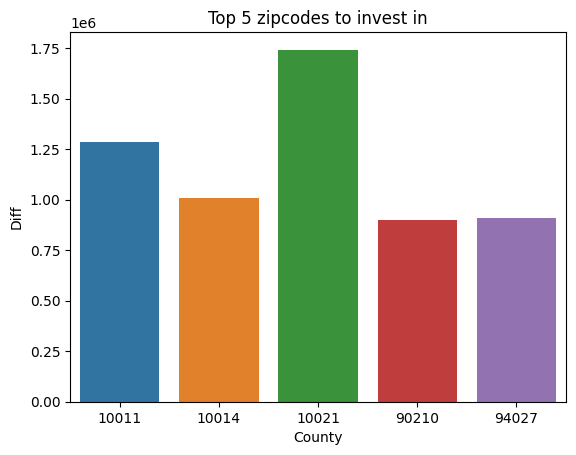

In [38]:
#Plotting the zipcodes with high forecasted values
avg_results = results_df.groupby('County')[['Forecast', 'Real']].mean().reset_index()
avg_results['Diff'] =avg_results['Real'] - avg_results['Forecast']
top_5 = avg_results.sort_values(by='Diff', ascending=False).head(5)
sns.barplot(data=top_5, x='County', y='Diff')
plt.title("Top 5 zipcodes to invest in")
plt.show()

## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://w0.peakpx.com/wallpaper/957/661/HD-wallpaper-white-marble-white-stone-texture-marble-stone-background-white-stone.jpg)"><b><span style='color:black'> Auto arima model</span></b> </div>

After doing forecasting on the selected zipcodes using a baseline model, we go ahead and try to use the auto arima to get the best pdq combinations to minimze the AIC score. 

The idea of looping and using the **TrainTestSplit** comes in handy as various combinations are tried for every fold to get the lowest AIC scores. 

In [39]:
for county in unique_counties:
    county_data = df_model[df_model['RegionName'] == county]

    # Split the data 
    dates = county_data.index
    values = county_data['value'].values

    # accumulate results for each fold
    zip_train_dates, zip_test_dates = [], []
    zip_train_values, zip_test_values = [], []

    for train_index, test_index in tsc.split(dates):
        train_dates, test_dates = dates[train_index], dates[test_index]
        train_values, test_values = values[train_index], values[test_index]

        zip_train_dates.extend(train_dates)
        zip_test_dates.extend(test_dates)
        zip_train_values.extend(train_values)
        zip_test_values.extend(test_values)

        
        auto_model = auto_arima(train_values, trace=True, suppress_warnings=True)
        auto_model.summary()
    

NameError: name 'auto_arima' is not defined

## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://w0.peakpx.com/wallpaper/957/661/HD-wallpaper-white-marble-white-stone-texture-marble-stone-background-white-stone.jpg)"><b><span style='color:black'> ARIMA(0,2,0)</span></b> </div>

From the various pdq combinations, the one with the lowest score accross several folds is **0,2,0** and **1,2,1**. These are the combinations to test out on the **ARMA** models and analyze their AIC scores. This is because most time series models are prone to overfitting and as such there is need to test out more than one comnination. 

In [40]:

def model_func(order):
    results_list2 = []
    for county in unique_counties:
        county_data = df_model[df_model['RegionName'] == county]

        # Split the data 
        dates = county_data.index
        values = county_data['value'].values

        # accumulate values for each fold
        zip_train_dates, zip_test_dates = [], []
        zip_train_values, zip_test_values = [], []

        for train_index, test_index in tsc.split(dates):
            train_dates, test_dates = dates[train_index], dates[test_index]
            train_values, test_values = values[train_index], values[test_index]

            zip_train_dates.extend(train_dates)
            zip_test_dates.extend(test_dates)
            zip_train_values.extend(train_values)
            zip_test_values.extend(test_values)

            
            model = ARIMA(train_values, order=order).fit()
            forecast = pd.Series(model.predict(start=len(train_values), end=len(train_values) + 11, typ='levels'))
            
            print(model.summary())

            all_forecasts.extend(forecast)

        
            forecasted_value = forecast.iloc[-1]
            real_value = test_values[-1]
            percentage_change = ((forecasted_value - real_value) / real_value) * 100

            results_df = pd.DataFrame(results_list2.append({'County': county, 'Forecast': forecasted_value, 'Real': real_value, 'Percentage Change': percentage_change}))
            
    return results_df    

In [41]:
model_func(order=(0,2,0))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:                 ARIMA(0, 2, 0)   Log Likelihood                -387.275
Date:                Thu, 18 Jan 2024   AIC                            776.550
Time:                        19:54:00   BIC                            777.951
Sample:                             0   HQIC                           776.998
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       8.94e+09   1.86e+09      4.802      0.000    5.29e+09    1.26e+10
Ljung-Box (L1) (Q):                  23.71   Jarque-Bera (JB):                 1.48
Prob(Q):                              0.00   Pr

""


This model generates an AIC score of 776 which is pretty much lower than the baseline's model score of 891.

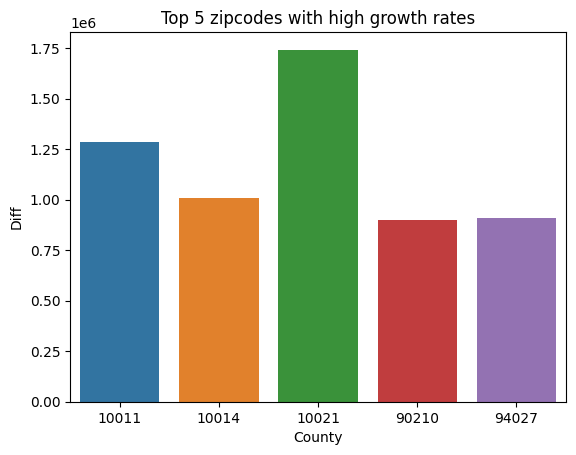

In [42]:
avg_results2 = results_df.groupby('County')[['Forecast', 'Real']].mean().reset_index()
avg_results2['Diff'] =avg_results['Real'] - avg_results2['Forecast']
top_5 = avg_results2.sort_values(by='Diff', ascending=False).head(5)
sns.barplot(data=top_5, x='County', y='Diff')
plt.title("Top 5 zipcodes with high growth rates")
plt.show()

## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://w0.peakpx.com/wallpaper/957/661/HD-wallpaper-white-marble-white-stone-texture-marble-stone-background-white-stone.jpg)"><b><span style='color:black'> ARIMA(1,2,1)</span></b> </div>

In [44]:
model_func(order=(1,2,1))

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   32
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -387.712
Date:                Thu, 18 Jan 2024   AIC                            781.424
Time:                        19:59:10   BIC                            785.627
Sample:                             0   HQIC                           782.768
                                 - 32                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.091     10.970      0.000       0.821       1.179
ma.L1         -1.0000      0.279     -3.589      0.000      -1.546      -0.454
sigma2      7.496e+09   3.72e-11   2.02e+20      0.0

""


This model generates a higher AIC than the previous model. We aim to reduce the AIC scores. 

## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://w0.peakpx.com/wallpaper/957/661/HD-wallpaper-white-marble-white-stone-texture-marble-stone-background-white-stone.jpg)"><b><span style='color:black'> FaceBook model</span></b> </div>

After testing out the various ARIMA models, we seek to try out the **FaceBook** prophet model which handles the concept of seasonalty pretty well. The prophet model however requires the data columns to be in **ds** for the date column and **y** for the target column.

To have a simple modelling process, we reset the index for the modelling data to make the time column extraction easy using the loop and later save the results to a CSV file. This data will be processed through an **Extract-Transform-Load** pipeline having the Prophet model. 

The concept of automation is very paramount because it helps in easier code manageability and debugging. It also offers better scalability especially when dealing with huge projects.
this is manageable by using the traditional **OOP** approach where everything is automated from the ingestion of data, renaming of columns, dropping null values, training, evaluating a model and later saving the model for future deployment purposes. 


In [45]:
df_model.reset_index(inplace=True)

In [46]:
for county in unique_counties:
    county_data = df_model[df_model['RegionName'] == county][['time', 'value']].copy()
    county_data.to_csv('Zipcode_predict.csv')

### <b><span style='color:#16C2D5'>|</span> Average House prediction</b>

The data to be used in the forecasting of the average house prices for every month comes from the melt function. The data is aggregated on a monthly basis togther with their respective average values. 

20:14:16 - cmdstanpy - INFO - Chain [1] start processing
20:14:47 - cmdstanpy - INFO - Chain [1] done processing


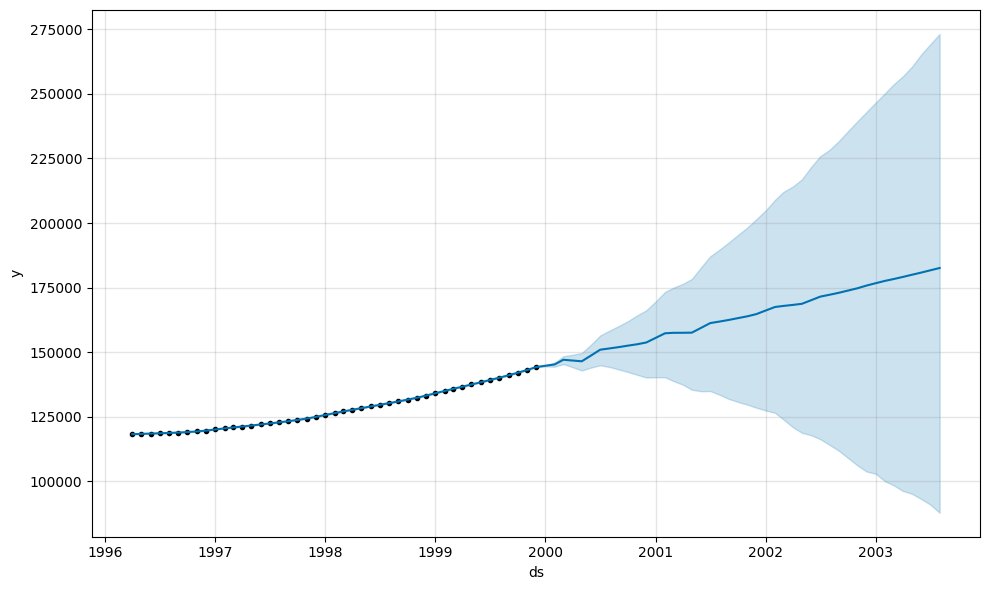

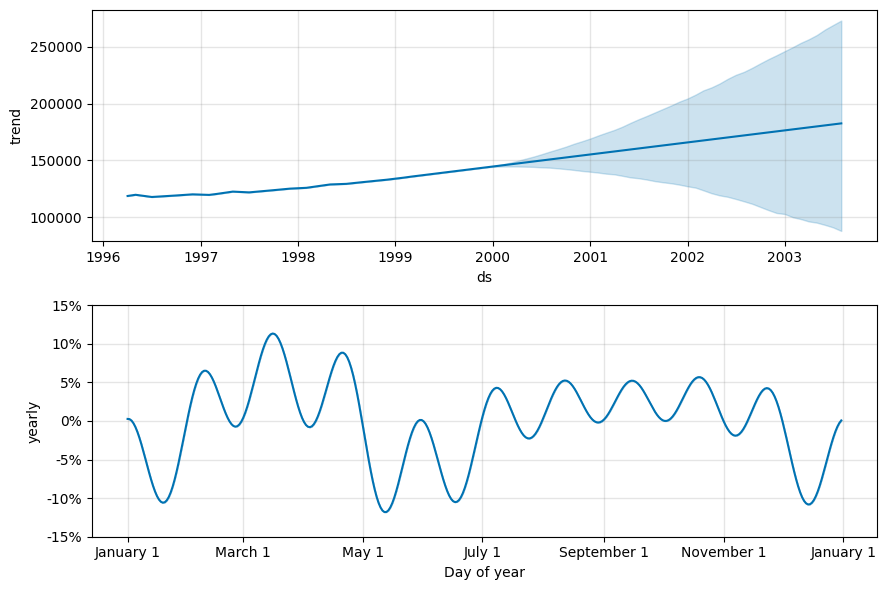

20:14:48 - cmdstanpy - INFO - Chain [1] start processing
20:14:49 - cmdstanpy - INFO - Chain [1] done processing


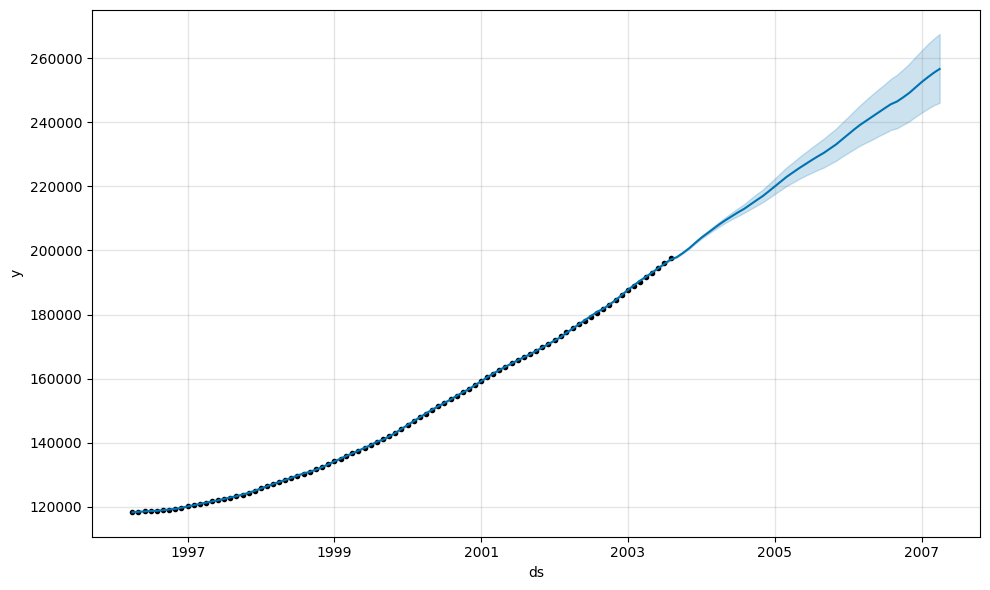

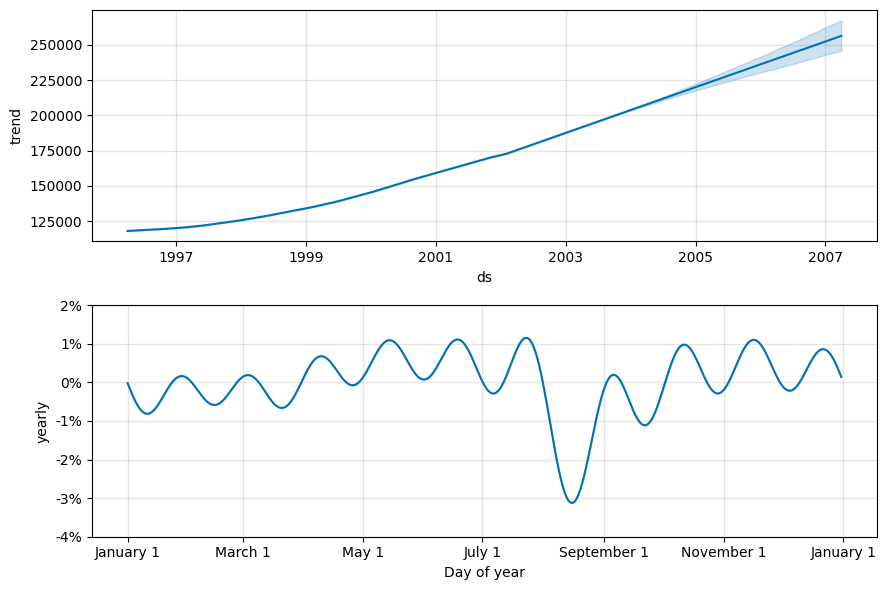

20:14:50 - cmdstanpy - INFO - Chain [1] start processing
20:14:51 - cmdstanpy - INFO - Chain [1] done processing


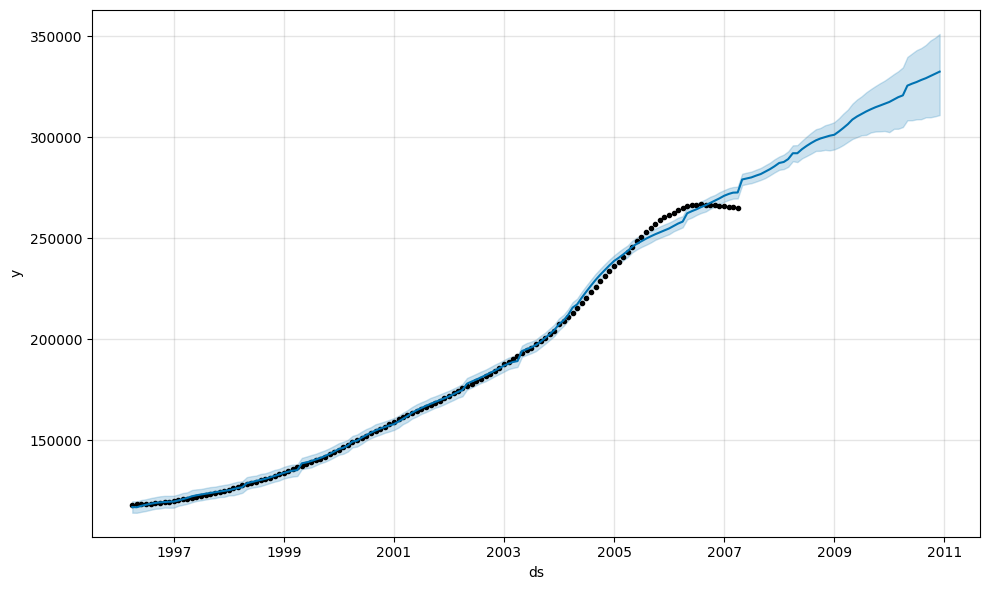

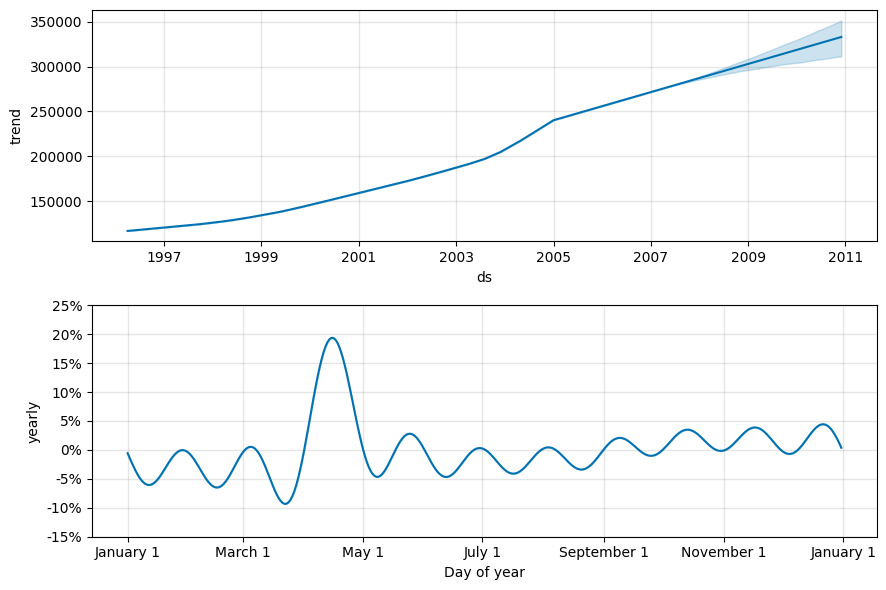

20:14:52 - cmdstanpy - INFO - Chain [1] start processing
20:14:52 - cmdstanpy - INFO - Chain [1] done processing


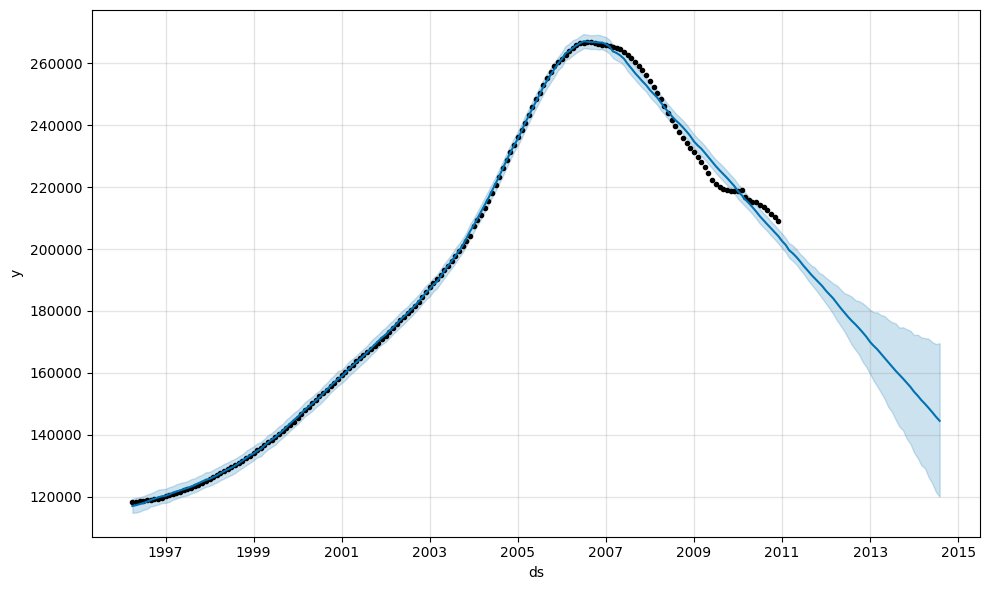

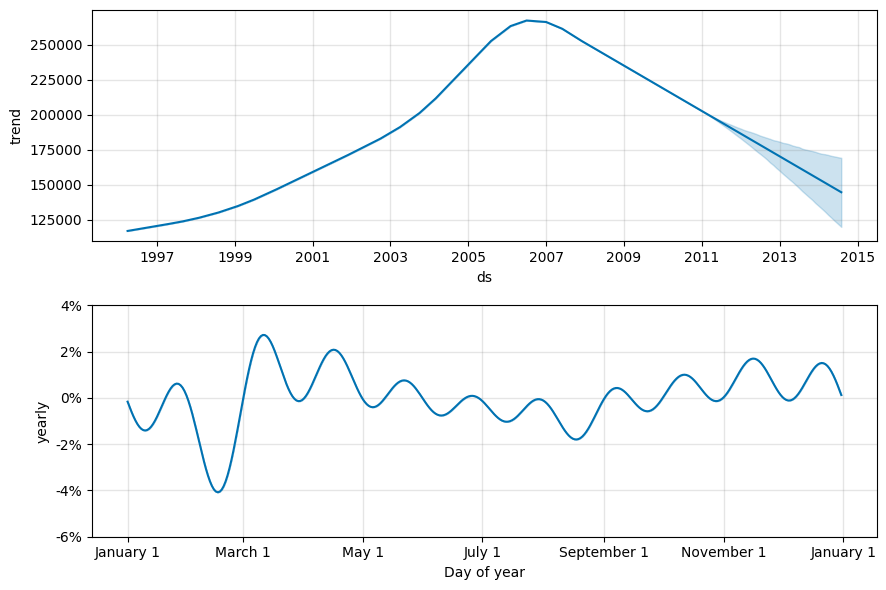

20:14:53 - cmdstanpy - INFO - Chain [1] start processing
20:14:53 - cmdstanpy - INFO - Chain [1] done processing


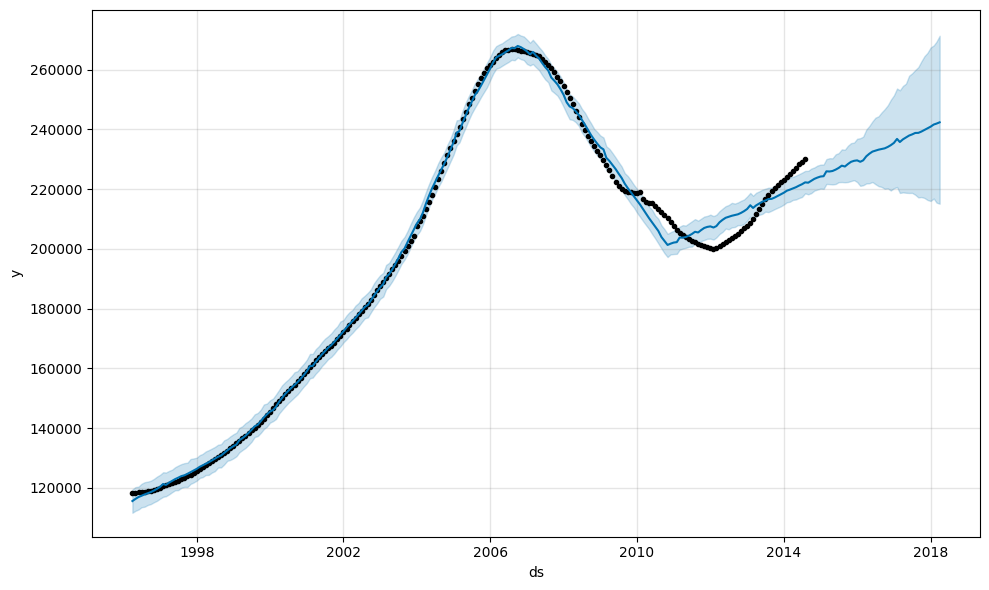

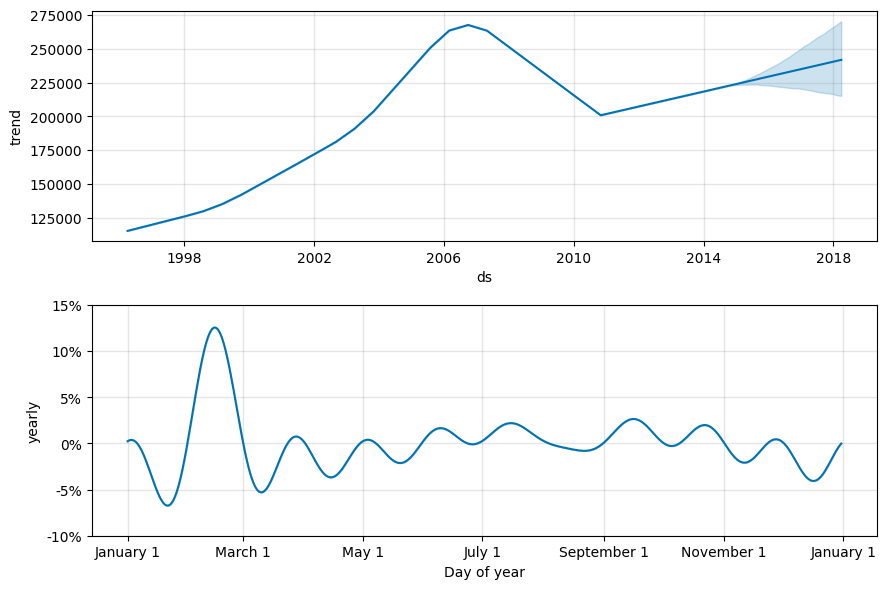

In [48]:

class TimeSeriesPipeline:
    def __init__(self, data_path, n_splits=5):
        self.data_path = data_path
        self.data = None
        self.model = None
        self.forecast = None
        self.n_splits = n_splits

    def load_data(self):
        self.data = pd.read_excel(self.data_path)

    def preprocess_data(self, target_column='y', ds_column='ds'):
        self.data[ds_column] = pd.to_datetime(self.data[ds_column])
        self.data = self.data.rename(columns={ds_column: 'ds', target_column: 'y'})

        if self.data.duplicated('ds').any():
            self.data = self.data.drop_duplicates(subset='ds', keep='first')

    def train_model(self, train_data):
        self.model = Prophet(seasonality_mode='multiplicative')
        self.model.fit(train_data)

    def make_predictions(self, test_data):
        future = self.model.make_future_dataframe(periods=len(test_data), freq='MS')
        self.forecast = self.model.predict(future)

    def plot_forecast(self):
        fig = self.model.plot(self.forecast)
        fig2 = self.model.plot_components(self.forecast)
        plt.show()

    def evaluate_model(self, test_data, y_true='y', y_pred='yhat'):
        y_true = test_data[y_true].values
        y_pred = self.forecast[-len(test_data):][y_pred].values
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)

        return r2, mse, rmse

    def run_pipeline(self, target_column='y', ds_column='ds'):
        self.load_data()
        self.preprocess_data(target_column=target_column, ds_column=ds_column)

        tscv = TimeSeriesSplit(n_splits=self.n_splits)
        for train_index, test_index in tscv.split(self.data):
            train_data, test_data = self.data.iloc[train_index], self.data.iloc[test_index]

            self.train_model(train_data)
            self.make_predictions(test_data)
            self.plot_forecast()
            self.evaluate_model(test_data, y_true='y', y_pred='yhat')


class SaveModel(TimeSeriesPipeline):
    def save_model(self, model_path='house_value_predictor.pkl'):
        joblib.dump(self.model, model_path)


data_path = "output_2.xlsx"
target_column = 'y'
pipeline = SaveModel(data_path)
pipeline.run_pipeline(target_column='value', ds_column='time')
pipeline.save_model()


Working with the ETL pipeline produces the best results because the training and test sets are split into folds. This provides a cross validation technique. From the plots, the model learns the pattern pretty well even during the 2008 crisis. 

Doing a cross validation of every split to get the test scores for the **evaluate model** is however not feasible because of larget training times it takes. It is for this reason that we opt to depend on the visualization of forecasted and real values. 

The prophet model learns the seasonality in the zillow housing data as shown by the plots of every fold. The forecast shows a steady rise of home value for the specified zipcodes. 

There is an yearly season where the house values normally peak December. 

### <b> <span style='color:#16C2D5'>|</span> ZipCodes house prediction</b>

Using the data saved in the csv file **Zipcode_predict.csv**, we set out to investigate how the facebook prophet handles the predictions for the top 30 zipcodes that had houses with higher values.

Just like before, obtaining the scores from the model seems pretty time consuming and may not be feasible at this time. 

20:03:43 - cmdstanpy - INFO - Chain [1] start processing
20:03:44 - cmdstanpy - INFO - Chain [1] done processing


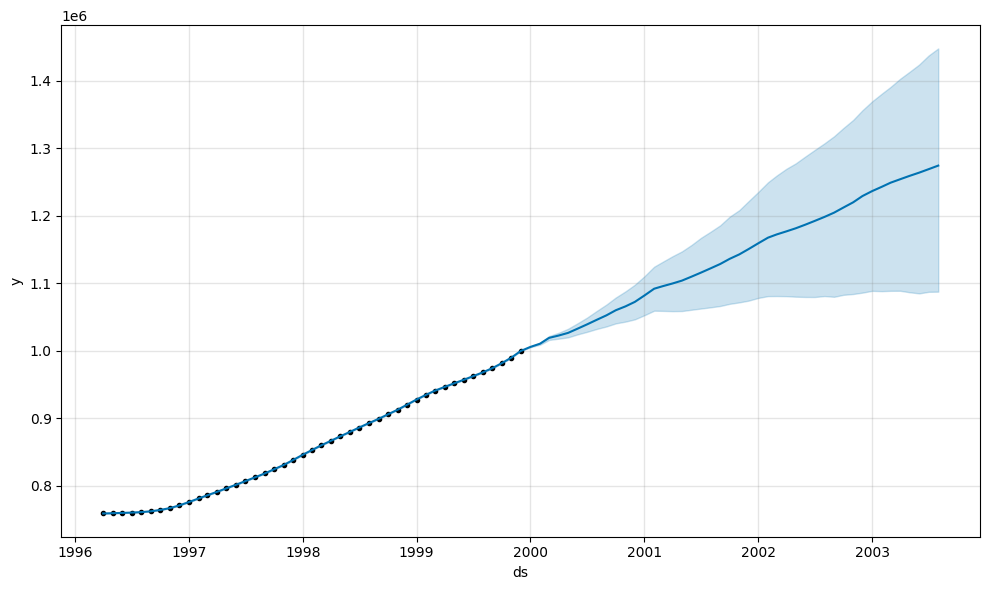

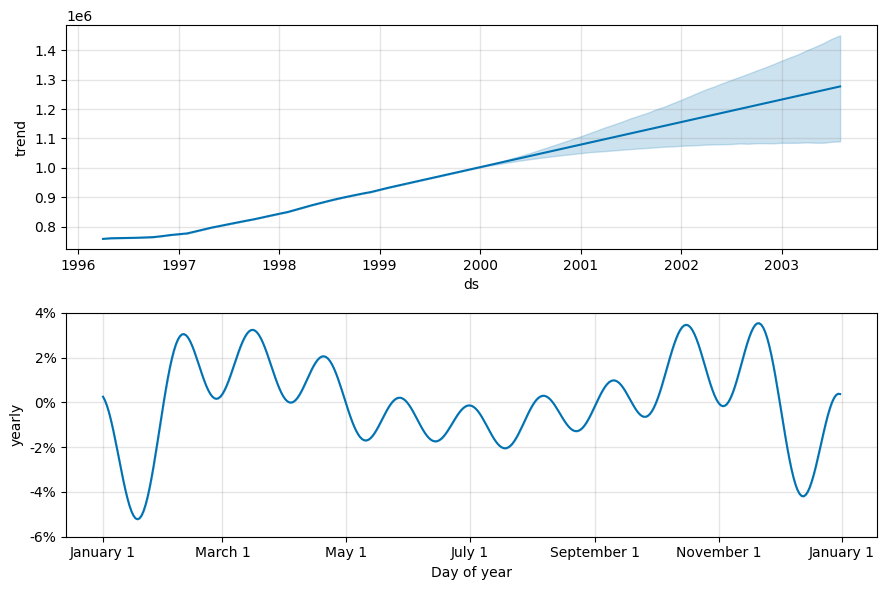

20:03:47 - cmdstanpy - INFO - Chain [1] start processing
20:03:48 - cmdstanpy - INFO - Chain [1] done processing


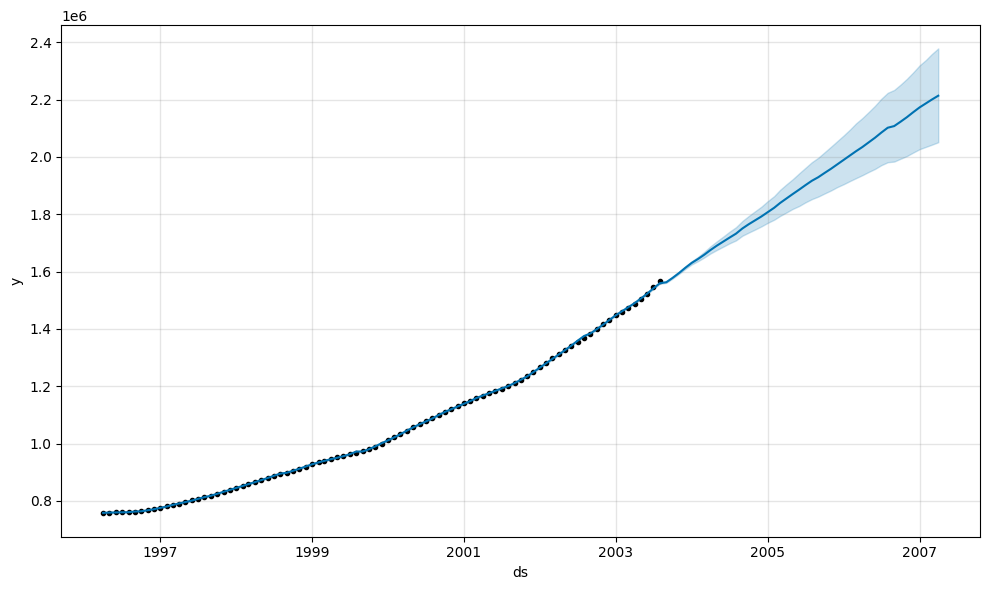

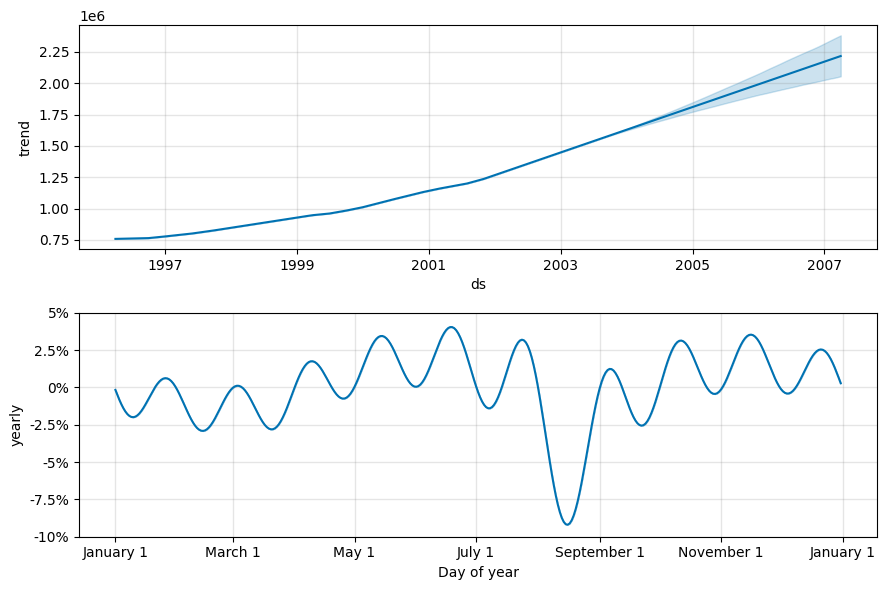

20:03:49 - cmdstanpy - INFO - Chain [1] start processing
20:03:49 - cmdstanpy - INFO - Chain [1] done processing


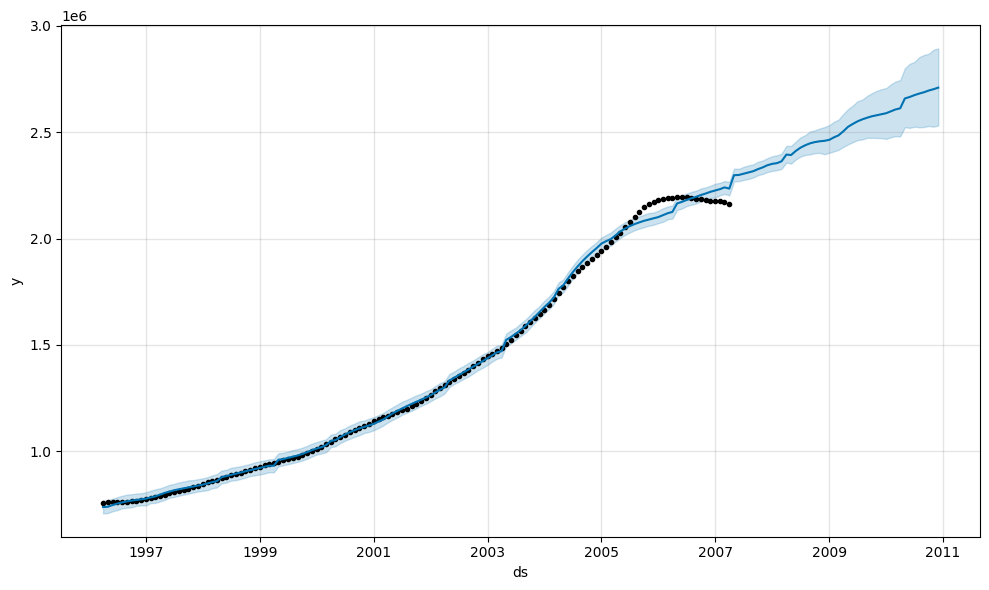

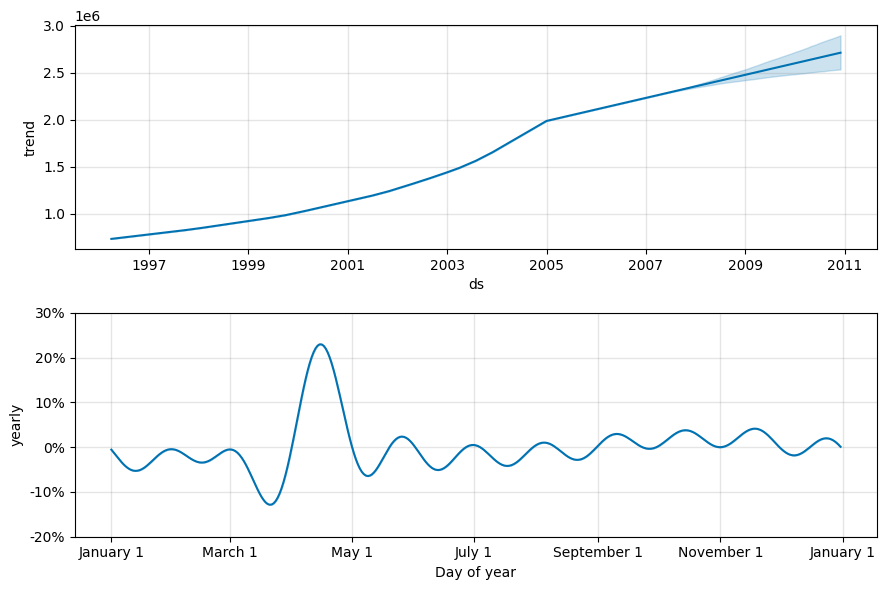

20:03:50 - cmdstanpy - INFO - Chain [1] start processing
20:03:50 - cmdstanpy - INFO - Chain [1] done processing


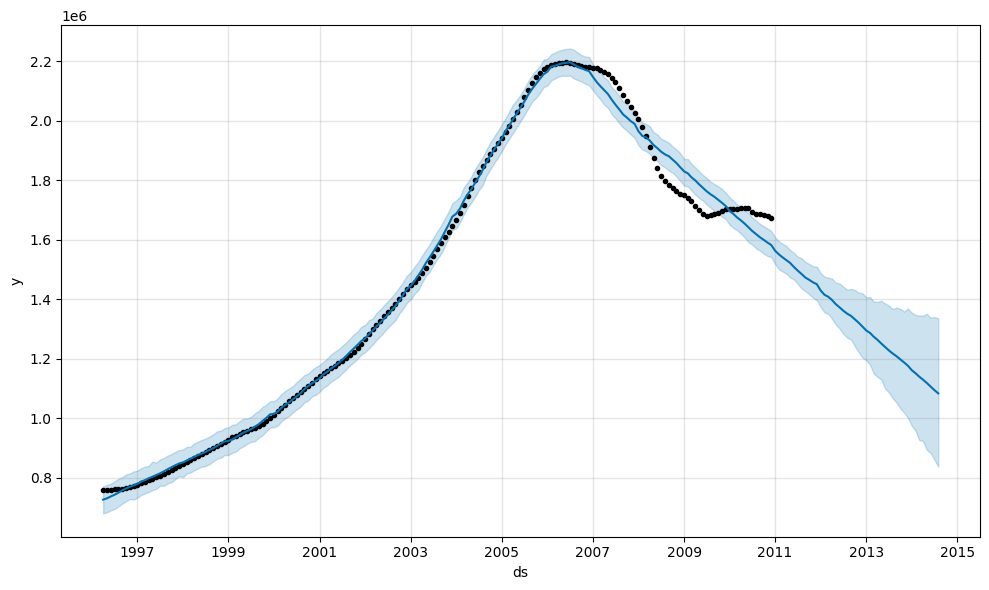

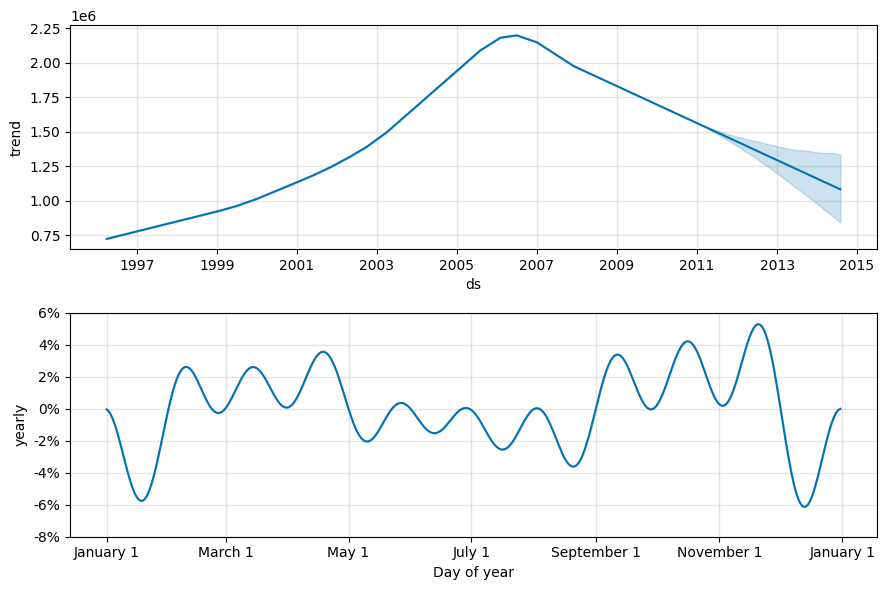

20:03:51 - cmdstanpy - INFO - Chain [1] start processing
20:03:52 - cmdstanpy - INFO - Chain [1] done processing


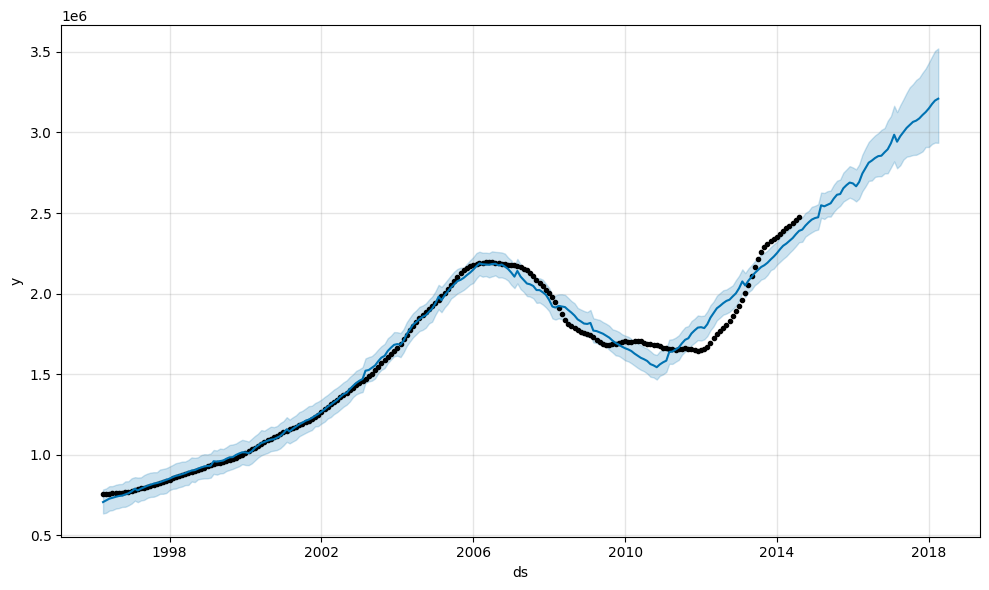

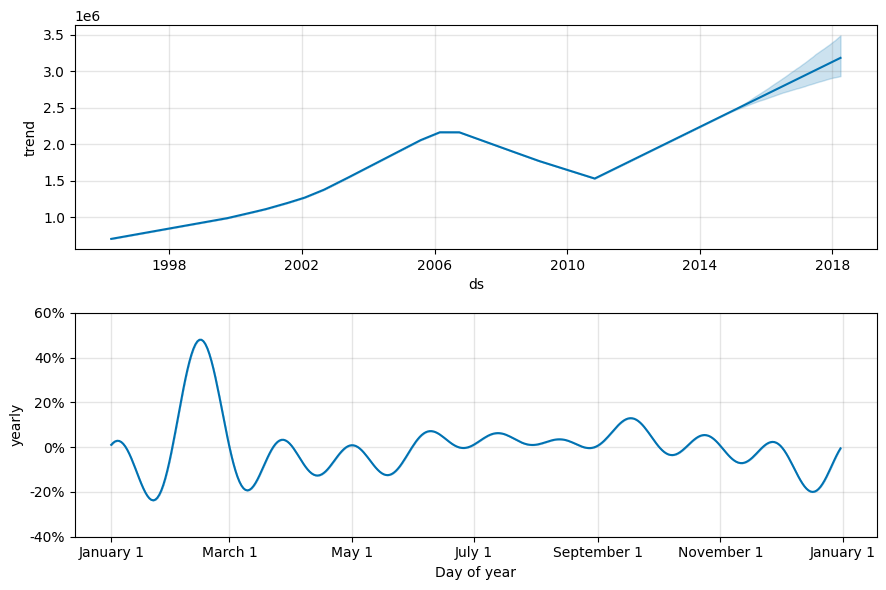

In [47]:

class TimeSeriesPipeline2:
    def __init__(self, data_path, n_splits=5):
        self.data_path = data_path
        self.data = None
        self.model = None
        self.forecast = None
        self.n_splits = n_splits

    def load_data(self):
        self.data = pd.read_csv(self.data_path)

    def preprocess_data(self, target_column='y', ds_column='ds'):
        self.data[ds_column] = pd.to_datetime(self.data[ds_column])
        self.data = self.data.rename(columns={ds_column: 'ds', target_column: 'y'})

        if self.data.duplicated('ds').any():
            self.data = self.data.drop_duplicates(subset='ds', keep='first')

    def train_model(self, train_data):
        self.model = Prophet(seasonality_mode='multiplicative')
        self.model.fit(train_data)

    def make_predictions(self, test_data):
        future = self.model.make_future_dataframe(periods=len(test_data), freq='MS')
        self.forecast = self.model.predict(future)

    def plot_forecast(self):
        fig = self.model.plot(self.forecast)
        fig2 = self.model.plot_components(self.forecast)
        plt.show()

    def evaluate_model(self, test_data, y_true='y', y_pred='yhat'):
        y_true = test_data[y_true].values
        y_pred = self.forecast[-len(test_data):][y_pred].values
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)

        return r2, mse, rmse

    def run_pipeline(self, target_column='y', ds_column='ds'):
        self.load_data()
        self.preprocess_data(target_column=target_column, ds_column=ds_column)

        tscv = TimeSeriesSplit(n_splits=self.n_splits)
        for train_index, test_index in tscv.split(self.data):
            train_data, test_data = self.data.iloc[train_index], self.data.iloc[test_index]

            self.train_model(train_data)
            self.make_predictions(test_data)
            self.plot_forecast()
            self.evaluate_model(test_data, y_true='y', y_pred='yhat')


class SaveModel(TimeSeriesPipeline2):
    def save_model(self, model_path='zipCode_value_predictor.pkl'):
        joblib.dump(self.model, model_path)


data_path = "Zipcode_predict.csv"
target_column = 'y'
pipeline = SaveModel(data_path)
pipeline.run_pipeline(target_column='value', ds_column='time')
pipeline.save_model()


From the plots, what can be deduced is that the model predicts an upward trend of house prices in the specific ZipCodes and in the event of any future crisis, the model has demonstrated its capability of learning the patterns and trends exhibited by the data. 

### <b><span style='color:#16C2D5'>|</span> Modelling Conclusion</b> 

Three models were used specifically the baseline ARIMA model, the auto arima model to find the best pdq combinations, ARIMA models with the best combination sto minimize the AIC scores and finally the prophet model using an ETL pipeline. 

The ARIMA model with the lowest AIC scores of **716** was the one of order **0,2,0**. This model gave us the best possible forecasted values to answer our business objective. To find the forecasted value for each zipcode, the forecasted value was averaged.

The use of **TimeSeriesSplit** as a cross validation technique came in handy. This is because the data in the training and test sets is split into folds so as to get a variety of several forecasted value for each zipCode. These forecasted values are then averaged to get the real forecast value for every zipCode. 

The **Facebook** model also came in handy because it handles seasonality well especially with the financial crisis in 2008 when house prices tanked. From the plots, the model showed an upward trend of house prices in the zipcodes but each with a different percentage as observed from the forecasted results best ARIMA model. This model captured the seasonality and from the plots, it is clear houses fetch for higher prices between December.

In the event of any future financial crisis, the facebook prophet model has parameters which can be adjusted to capture the seasonality and learn the pattern in data. The parameters include:
* The add_seasonality function
* Adjusting the fourier order to capture complex seasonality(High fourier orders capture complex patterns)
* Adding other regressors which may impact on the way the model learns the data.

With all this said, the **Prophet** model has very useful parameters that can be adjusted in the event of any crisis. 

The models to forecast both the average monthly house values and the zip codes values have been saved to pickle files and may be used during the production and deployment process because they exhibit great learning patterns. 



## <div style="padding: 20px;color:white;margin:10;font-size:90%;text-align:left;display:fill;border-radius:10px;overflow:hidden;background-image: url(https://w0.peakpx.com/wallpaper/957/661/HD-wallpaper-white-marble-white-stone-texture-marble-stone-background-white-stone.jpg)"><b><span style='color:black'> 4. Conclusion</span></b> </div>


## 4. ARIMA MODELLING

## 5. FINE TUNING WITH PROPHET

## 6. INTERPRETING RESULTS